In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.svm import SVR
import xgboost as xgb
from tensorflow.keras.layers import LSTM, Dense, GRU


In [3]:
def linegraph(train_dates, y_train, test_dates, y_test, predictions):
    train = pd.DataFrame({
        'Date': train_dates,
        'Close': y_train
    })
    valid = pd.DataFrame({
        'Date': test_dates,
        'Close': y_test,
        'Predictions': predictions
    })

    # Visualize the data
    plt.figure(figsize=(16, 6))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price', fontsize=18)
    plt.plot(train['Date'], train['Close'], label='Train')
    plt.plot(valid['Date'], valid['Close'], label='Validation')
    plt.plot(valid['Date'], valid['Predictions'], label='Predictions')
    plt.legend(loc='lower right')
    plt.show()

# Random Forest

In [4]:
def run_random_forest(DF, n_estimators, random_state,Features, Target):
  
    features = Features
    target = Target
    # Splitting data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        DF[features + ['Date']],
        DF[target],
        test_size=0.2,
        random_state=random_state,
        shuffle=False
    )
    
    # Saving the 'Date' column for potential use and then dropping it from training and testing datasets
    train_dates = X_train['Date']
    test_dates = X_test['Date']
    X_train.drop(['Date'], axis=1, inplace=True)
    X_test.drop(['Date'], axis=1, inplace=True)
    
    # Creating and fitting the RandomForestRegressor
    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    rf_model.fit(X_train, y_train)
    
    # Making predictions
    predictions = rf_model.predict(X_test)
    
    # Evaluating the model
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    
    # Print results
    print(f'Mean Squared Error: {mse:.3f}')
    print(f'Root Mean Squared Error: {rmse:.3f}')
    print(f'R-squared Score: {r2:.3f}')
    linegraph(train_dates, y_train, test_dates, y_test, predictions)
    # Optionally, return these metrics if you want to use them later
    return mse, rmse, r2

# SVR

In [5]:
def run_svr(Df, random_state, Features, Target):
    DF = Df
    features = Features
    target = Target
    dates = DF['Date'].values  
    
    # Initialize separate scalers for features and target
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    # Scale features and target separately
    DF_features_scaled = feature_scaler.fit_transform(DF[features])
    DF_target_scaled = target_scaler.fit_transform(DF[[target]]) 
    
    sequence_length = 10
    X, y, X_dates = [], [], []
    for i in range(len(DF_features_scaled) - sequence_length):
        X.append(DF_features_scaled[i:(i + sequence_length), :])
        y.append(DF_target_scaled[i + sequence_length, 0])
        X_dates.append(dates[i + sequence_length])
    
    X, y, X_dates = np.array(X), np.array(y), np.array(X_dates)
    
    # Splitting dataset
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    train_dates, test_dates = X_dates[:train_size], X_dates[train_size:]
    
    svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
    svr_model.fit(X_train.reshape(X_train.shape[0], -1), y_train.ravel())

    y_pred = svr_model.predict(X_test.reshape(X_test.shape[0], -1))

    # Inverse transform the predictions and actuals using the correct scaler
    y_pred_inv = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_train_inv = target_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()

    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_inv, y_pred_inv)
   
    print(f'Mean Squared Error (MSE): {mse:.3f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')
    print(f'R-squared Score (R2): {r2:.3f}')

# LSTM

In [6]:
def LSTM_Model(dataFrame,Features, Target, epochs, batch_size):
    DF=dataFrame
    features = Features
    target=Target
    dates = DF['Date'].values
    print(features)
    print(target)
    print(epochs)
    print(batch_size)
    # Data scaling
    scaler = MinMaxScaler()
    DF_scaled = scaler.fit_transform(DF[features + [target]])
    
    # Preparing input sequences
    sequence_length = 10
    X, y, X_dates = [], [], []
    for i in range(len(DF_scaled) - sequence_length):
        X.append(DF_scaled[i:(i + sequence_length), :-1])
        y.append(DF_scaled[i + sequence_length, -1])
        X_dates.append(dates[i + sequence_length])
    X, y, X_dates = np.array(X), np.array(y), np.array(X_dates)
    y = y.reshape(-1, 1)
    
    # Splitting dataset
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    train_dates, test_dates = X_dates[:train_size], X_dates[train_size:]
    
    # Model building
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Model training
    model.fit(X_train, y_train,epochs=epochs, batch_size=batch_size, verbose=2)
    
    # Model prediction
    y_pred = model.predict(X_test)
    X_test_reshaped = X_test[:, -1, :].reshape(X_test.shape[0], -1)
    y_pred_inv = scaler.inverse_transform(np.concatenate((X_test_reshaped, y_pred), axis=1))[:, -1]
    y_test_inv = scaler.inverse_transform(np.concatenate((X_test_reshaped, y_test.reshape(-1, 1)), axis=1))[:, -1]
    train_inv_y = scaler.inverse_transform(np.concatenate((X_train[:, -1, :], y_train.reshape(-1, 1)), axis=1))[:, -1]
    
    # Evaluation
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_inv, y_pred_inv)
    
    # Print results
    print(f'Mean Squared Error (MSE): {mse:.3f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')
    print(f'R-squared Score (R2): {r2:.3f}')
    
    return train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv

# Gated Recurrent Units GRU

In [7]:
def GRU_Model(dataFrame,Features, Target, epochs, batch_size):
    TestDF = dataFrame
    target = Target
    features = Features
    print(features)
    print(target)
    print(epochs)
    print(batch_size)
    scaler = MinMaxScaler()
    TestDF[features] = scaler.fit_transform(TestDF[features])
    TestDF[target] = scaler.fit_transform(TestDF[[target]])
    def create_sequences(X, y, time_steps=1):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            Xs.append(X.iloc[i:(i + time_steps)].values)
            ys.append(y.iloc[i + time_steps])
        return np.array(Xs), np.array(ys)

    time_steps = 10

    X, y = create_sequences(TestDF[features], TestDF[target], time_steps)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, shuffle=False)

    model = Sequential([
        GRU(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        GRU(50),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    predictions = model.predict(X_test)

    predictions = scaler.inverse_transform(predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test_rescaled, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_rescaled, predictions)

    print(f'Mean Squared Error (MSE): {mse:.3f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')
    print(f'R-squared Score (R2): {r2:.3f}')

# XGBoost

In [8]:
def run_xgboost(Data, Features, Target, random_state):
    
    DF = Data
    features = Features
    target = Target
    # Splitting data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        DF[features + ['Date']],
        DF[target],
        test_size=0.2,
        random_state=random_state,
        shuffle=False
    )
    
    train_dates = X_train['Date']
    test_dates = X_test['Date']
    X_train.drop(['Date'], axis=1, inplace=True)
    X_test.drop(['Date'], axis=1, inplace=True)
    
    model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                             max_depth = 5, alpha = 10, n_estimators = 100)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("R-squared:", r2)
    linegraph(train_dates, y_train, test_dates, y_test, y_pred)

In [9]:
Data = pd.read_csv("Data2/JAMUNAOIL_data.csv")

In [10]:
Data.head()

,Date,Open,High,Low,Close,Volume
0,10/1/2012,171.7101,174.8252,170.3751,171.7737,504461
1,10/2/2012,174.1895,176.7959,173.2994,176.1602,1000428
2,10/3/2012,177.9402,187.5397,176.7324,185.5690,4027824
3,10/4/2012,187.5397,193.8334,184.9968,187.1583,2158156
4,10/7/2012,187.6669,196.4399,184.3611,189.1291,2061102


In [12]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2677 entries, 0 to 2676
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2677 non-null   object 
 1   Open    2677 non-null   float64
 2   High    2677 non-null   float64
 3   Low     2677 non-null   float64
 4   Close   2677 non-null   float64
 5   Volume  2677 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 125.6+ KB


In [13]:
Data['Date'] = pd.to_datetime(Data['Date'])

In [14]:
Data.head()

,Date,Open,High,Low,Close,Volume
0,2012-10-01,171.7101,174.8252,170.3751,171.7737,504461
1,2012-10-02,174.1895,176.7959,173.2994,176.1602,1000428
2,2012-10-03,177.9402,187.5397,176.7324,185.5690,4027824
3,2012-10-04,187.5397,193.8334,184.9968,187.1583,2158156
4,2012-10-07,187.6669,196.4399,184.3611,189.1291,2061102


In [15]:
Data = Data[Data['Date'] >= '2021-01-01']

In [16]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 757 entries, 1920 to 2676
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    757 non-null    datetime64[ns]
 1   Open    757 non-null    float64       
 2   High    757 non-null    float64       
 3   Low     757 non-null    float64       
 4   Close   757 non-null    float64       
 5   Volume  757 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 41.4 KB


In [17]:
Data.describe()

,Date,Open,High,Low,Close,Volume
count,757,757.000000,757.000000,757.000000,757.000000,757.000000
mean,2022-08-01 15:13:04.676354048,171.236856,172.595641,170.089564,171.195905,30083.556143
min,2021-01-03 00:00:00,149.900000,151.500000,146.000000,148.600000,5.000000
25%,2021-10-26 00:00:00,167.300000,167.900000,167.200000,167.300000,7499.000000
50%,2022-08-03 00:00:00,171.000000,172.500000,169.900000,170.900000,16803.000000
75%,2023-05-16 00:00:00,177.300000,178.500000,176.700000,177.200000,33042.000000
max,2024-02-20 00:00:00,194.000000,199.800000,192.000000,192.100000,340297.000000
std,NaN,8.008911,8.219688,7.844950,7.922159,42507.760673


In [18]:
def fill_missing_with_mean(df):
    result = df.copy()
    for i in range(len(df)):
        if pd.isnull(df.iloc[i]):
            prev_index = i - 1
            next_index = i + 1
            while pd.isnull(df.iloc[prev_index]):
                prev_index -= 1
            while pd.isnull(df.iloc[next_index]):
                next_index += 1
            prev_val = df.iloc[prev_index] if prev_index >= 0 else np.nan
            next_val = df.iloc[next_index] if next_index < len(df) else np.nan
            if pd.notnull(prev_val) and pd.notnull(next_val):
                result.iloc[i] = (prev_val + next_val) / 2
    return result

# Feature Engineering

In [19]:
Data.set_index('Date', inplace=True)

In [20]:
all_dates = pd.date_range(start=Data.index.min(), end=Data.index.max(), freq='D')

In [21]:
Data = Data.reindex(all_dates)

In [22]:
Data.head(15)

,Open,High,Low,Close,Volume
2021-01-03,166.9,169.0,165.0,167.9,156205.0
2021-01-04,167.1,170.0,166.6,168.6,89695.0
2021-01-05,169.6,173.2,169.1,169.6,98023.0
2021-01-06,172.0,172.0,168.5,170.5,50243.0
2021-01-07,171.9,172.0,168.4,169.3,94333.0
2021-01-08,NaN,NaN,NaN,NaN,NaN
2021-01-09,NaN,NaN,NaN,NaN,NaN
2021-01-10,169.3,170.8,168.0,169.1,90042.0
2021-01-11,169.1,171.6,168.2,171.2,100656.0
2021-01-12,170.0,174.6,170.0,174.5,171872.0


In [23]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1144 entries, 2021-01-03 to 2024-02-20
Freq: D
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    757 non-null    float64
 1   High    757 non-null    float64
 2   Low     757 non-null    float64
 3   Close   757 non-null    float64
 4   Volume  757 non-null    float64
dtypes: float64(5)
memory usage: 53.6 KB


In [24]:
Df = fill_missing_with_mean(Data['Open'])
Data['Open'] = Df

In [25]:
Data.head(15)

,Open,High,Low,Close,Volume
2021-01-03,166.90,169.0,165.0,167.9,156205.0
2021-01-04,167.10,170.0,166.6,168.6,89695.0
2021-01-05,169.60,173.2,169.1,169.6,98023.0
2021-01-06,172.00,172.0,168.5,170.5,50243.0
2021-01-07,171.90,172.0,168.4,169.3,94333.0
2021-01-08,170.60,NaN,NaN,NaN,NaN
2021-01-09,170.60,NaN,NaN,NaN,NaN
2021-01-10,169.30,170.8,168.0,169.1,90042.0
2021-01-11,169.10,171.6,168.2,171.2,100656.0
2021-01-12,170.00,174.6,170.0,174.5,171872.0


In [26]:
Df = fill_missing_with_mean(Data['High'])
Data['High'] = Df

In [27]:
Data.head(15)

,Open,High,Low,Close,Volume
2021-01-03,166.90,169.0,165.0,167.9,156205.0
2021-01-04,167.10,170.0,166.6,168.6,89695.0
2021-01-05,169.60,173.2,169.1,169.6,98023.0
2021-01-06,172.00,172.0,168.5,170.5,50243.0
2021-01-07,171.90,172.0,168.4,169.3,94333.0
2021-01-08,170.60,171.4,NaN,NaN,NaN
2021-01-09,170.60,171.4,NaN,NaN,NaN
2021-01-10,169.30,170.8,168.0,169.1,90042.0
2021-01-11,169.10,171.6,168.2,171.2,100656.0
2021-01-12,170.00,174.6,170.0,174.5,171872.0


In [28]:
Df = fill_missing_with_mean(Data['Low'])
Data['Low'] = Df

In [29]:
Data.head(15)

,Open,High,Low,Close,Volume
2021-01-03,166.90,169.0,165.00,167.9,156205.0
2021-01-04,167.10,170.0,166.60,168.6,89695.0
2021-01-05,169.60,173.2,169.10,169.6,98023.0
2021-01-06,172.00,172.0,168.50,170.5,50243.0
2021-01-07,171.90,172.0,168.40,169.3,94333.0
2021-01-08,170.60,171.4,168.20,NaN,NaN
2021-01-09,170.60,171.4,168.20,NaN,NaN
2021-01-10,169.30,170.8,168.00,169.1,90042.0
2021-01-11,169.10,171.6,168.20,171.2,100656.0
2021-01-12,170.00,174.6,170.00,174.5,171872.0


In [30]:
Df = fill_missing_with_mean(Data['Close'])
Data['Close'] = Df

In [31]:
Data.head(15)

,Open,High,Low,Close,Volume
2021-01-03,166.90,169.0,165.00,167.90,156205.0
2021-01-04,167.10,170.0,166.60,168.60,89695.0
2021-01-05,169.60,173.2,169.10,169.60,98023.0
2021-01-06,172.00,172.0,168.50,170.50,50243.0
2021-01-07,171.90,172.0,168.40,169.30,94333.0
2021-01-08,170.60,171.4,168.20,169.20,NaN
2021-01-09,170.60,171.4,168.20,169.20,NaN
2021-01-10,169.30,170.8,168.00,169.10,90042.0
2021-01-11,169.10,171.6,168.20,171.20,100656.0
2021-01-12,170.00,174.6,170.00,174.50,171872.0


In [32]:
Data['Volume'] = Data['Volume'].fillna(0)

In [33]:
Data.head(50)

,Open,High,Low,Close,Volume
2021-01-03,166.90,169.00,165.00,167.90,156205.0
2021-01-04,167.10,170.00,166.60,168.60,89695.0
2021-01-05,169.60,173.20,169.10,169.60,98023.0
2021-01-06,172.00,172.00,168.50,170.50,50243.0
2021-01-07,171.90,172.00,168.40,169.30,94333.0
2021-01-08,170.60,171.40,168.20,169.20,0.0
2021-01-09,170.60,171.40,168.20,169.20,0.0
2021-01-10,169.30,170.80,168.00,169.10,90042.0
2021-01-11,169.10,171.60,168.20,171.20,100656.0
2021-01-12,170.00,174.60,170.00,174.50,171872.0


In [34]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1144 entries, 2021-01-03 to 2024-02-20
Freq: D
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1144 non-null   float64
 1   High    1144 non-null   float64
 2   Low     1144 non-null   float64
 3   Close   1144 non-null   float64
 4   Volume  1144 non-null   float64
dtypes: float64(5)
memory usage: 53.6 KB


In [35]:
Data.reset_index(inplace=True)
Data.rename(columns={'index': 'Date'}, inplace=True)

In [36]:
Data['day'] = Data['Date'].dt.day
Data['month'] = Data['Date'].dt.month
Data['year'] = Data['Date'].dt.year


Create column for 1 day, 1 week, 15 days, 1 month prediction of closing price

In [37]:
Data['1_day'] = Data['Close'].shift(-1)
Data['1_week'] = Data['Close'].shift(-7)
Data['15_days'] = Data['Close'].shift(-15)
Data['1_month'] = Data['Close'].shift(-30)

In [38]:
Data.head(30)

,Date,Open,High,Low,Close,Volume,day,month,year,1_day,1_week,15_days,1_month
0,2021-01-03,166.90,169.00,165.00,167.90,156205.0,3,1,2021,168.60,169.10,173.50,157.20
1,2021-01-04,167.10,170.00,166.60,168.60,89695.0,4,1,2021,169.60,171.20,167.80,156.70
2,2021-01-05,169.60,173.20,169.10,169.60,98023.0,5,1,2021,170.50,174.50,162.10,155.60
3,2021-01-06,172.00,172.00,168.50,170.50,50243.0,6,1,2021,169.30,174.00,163.20,155.75
4,2021-01-07,171.90,172.00,168.40,169.30,94333.0,7,1,2021,169.20,173.90,162.35,155.75
5,2021-01-08,170.60,171.40,168.20,169.20,0.0,8,1,2021,169.20,175.45,162.35,155.90
6,2021-01-09,170.60,171.40,168.20,169.20,0.0,9,1,2021,169.10,175.45,161.50,156.00
7,2021-01-10,169.30,170.80,168.00,169.10,90042.0,10,1,2021,171.20,177.00,163.50,157.00
8,2021-01-11,169.10,171.60,168.20,171.20,100656.0,11,1,2021,174.50,173.50,161.50,158.00
9,2021-01-12,170.00,174.60,170.00,174.50,171872.0,12,1,2021,174.00,167.80,161.50,156.40


In [39]:
Data.describe()

,Date,Open,High,Low,Close,Volume,day,month,year,1_day,1_week,15_days,1_month
count,1144,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1143.000000,1137.000000,1129.000000,1114.000000
mean,2022-07-28 12:00:00,171.188811,172.579327,170.032736,171.142045,19906.688811,15.661713,6.306818,2022.090909,171.144882,171.154090,171.135164,171.249461
min,2021-01-03 00:00:00,149.900000,151.500000,146.000000,148.600000,0.000000,1.000000,1.000000,2021.000000,148.600000,148.600000,148.600000,148.600000
25%,2021-10-15 18:00:00,167.300000,167.900000,167.000000,167.300000,0.000000,8.000000,3.000000,2021.000000,167.300000,167.300000,167.300000,167.300000
50%,2022-07-28 12:00:00,171.000000,172.625000,169.900000,170.800000,7342.000000,16.000000,6.000000,2022.000000,170.800000,170.800000,170.800000,171.000000
75%,2023-05-10 06:00:00,177.362500,178.500000,176.600000,177.200000,22879.750000,23.000000,9.000000,2023.000000,177.200000,177.200000,177.250000,177.300000
max,2024-02-20 00:00:00,194.000000,199.800000,192.000000,192.100000,340297.000000,31.000000,12.000000,2024.000000,192.100000,192.100000,192.100000,192.100000
std,NaN,7.972206,8.227783,7.824879,7.923332,37388.318511,8.774819,3.531796,0.898402,7.926219,7.945996,7.968422,7.949742


# Missing Value

In [40]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1144 entries, 0 to 1143
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     1144 non-null   datetime64[ns]
 1   Open     1144 non-null   float64       
 2   High     1144 non-null   float64       
 3   Low      1144 non-null   float64       
 4   Close    1144 non-null   float64       
 5   Volume   1144 non-null   float64       
 6   day      1144 non-null   int32         
 7   month    1144 non-null   int32         
 8   year     1144 non-null   int32         
 9   1_day    1143 non-null   float64       
 10  1_week   1137 non-null   float64       
 11  15_days  1129 non-null   float64       
 12  1_month  1114 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int32(3)
memory usage: 102.9 KB


In [41]:
missing_values = Data.isnull().sum()
print(missing_values)

Date        0
Open        0
High        0
Low         0
Close       0
Volume      0
day         0
month       0
year        0
1_day       1
1_week      7
15_days    15
1_month    30
dtype: int64


In [42]:
Data=Data.dropna()

In [43]:
missing_values = Data.isnull().sum()
print(missing_values)

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
day        0
month      0
year       0
1_day      0
1_week     0
15_days    0
1_month    0
dtype: int64


# Check Outliers

In [44]:
Data[['Open','High','Low','Close']].describe()

,Open,High,Low,Close
count,1114.000000,1114.000000,1114.000000,1114.000000
mean,171.108169,172.488375,169.951930,171.060682
std,8.053527,8.306653,7.904232,8.005632
min,149.900000,151.500000,146.000000,148.600000
25%,167.300000,167.550000,167.000000,167.300000
50%,171.000000,172.300000,169.575000,170.700000
75%,177.487500,178.675000,176.600000,177.300000
max,194.000000,199.800000,192.000000,192.100000


<Axes: >

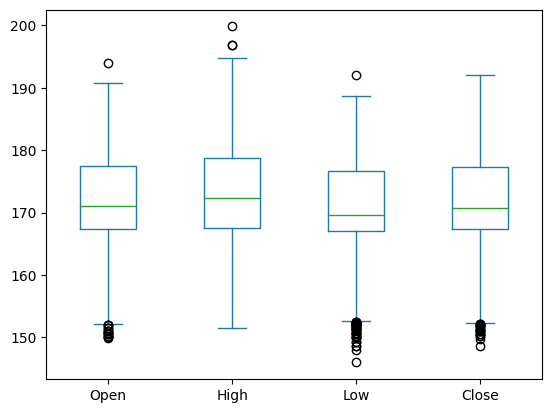

In [45]:
Data[['Open','High','Low','Close']].plot(kind='box')

<Axes: >

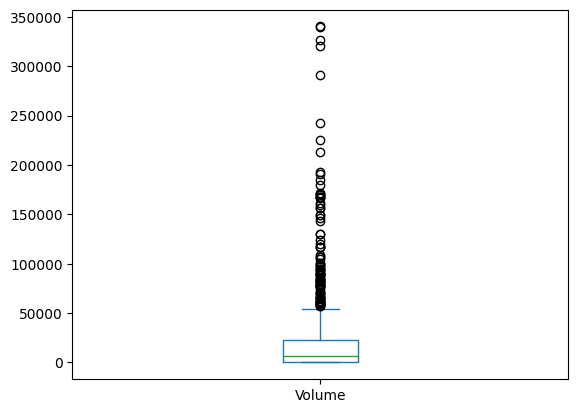

In [46]:
Data[['Volume']].plot(kind='box')

In [47]:
Data.describe()

,Date,Open,High,Low,Close,Volume,day,month,year,1_day,1_week,15_days,1_month
count,1114,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000
mean,2022-07-13 12:00:00,171.108169,172.488375,169.951930,171.060682,20022.099641,15.657092,6.431777,2022.039497,171.065440,171.079264,171.071634,171.249461
min,2021-01-03 00:00:00,149.900000,151.500000,146.000000,148.600000,0.000000,1.000000,1.000000,2021.000000,148.600000,148.600000,148.600000,148.600000
25%,2021-10-08 06:00:00,167.300000,167.550000,167.000000,167.300000,0.000000,8.000000,3.000000,2021.000000,167.300000,167.300000,167.300000,167.300000
50%,2022-07-13 12:00:00,171.000000,172.300000,169.575000,170.700000,6947.500000,16.000000,6.000000,2022.000000,170.700000,170.800000,170.750000,171.000000
75%,2023-04-17 18:00:00,177.487500,178.675000,176.600000,177.300000,22856.250000,23.000000,9.000000,2023.000000,177.300000,177.300000,177.300000,177.300000
max,2024-01-21 00:00:00,194.000000,199.800000,192.000000,192.100000,340297.000000,31.000000,12.000000,2024.000000,192.100000,192.100000,192.100000,192.100000
std,NaN,8.053527,8.306653,7.904232,8.005632,37832.575513,8.767385,3.493971,0.853228,8.005327,8.005087,8.002536,7.949742


In [48]:
close_prices = Data['Close']
Q1 = close_prices.quantile(0.25)
Q3 = close_prices.quantile(0.75)
print(Q1)
print(Q3)

167.3
177.3


In [49]:
IQR = Q3 - Q1
print(IQR)

10.0


In [50]:
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR
print(lower_bound)
print(upper_bound)

137.3
207.3


In [51]:
outliers = Data[(close_prices < lower_bound) | (close_prices > upper_bound)]
print(outliers)

Empty DataFrame
Columns: [Date, Open, High, Low, Close, Volume, day, month, year, 1_day, 1_week, 15_days, 1_month]
Index: []


No outliers

In [52]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1114 entries, 0 to 1113
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     1114 non-null   datetime64[ns]
 1   Open     1114 non-null   float64       
 2   High     1114 non-null   float64       
 3   Low      1114 non-null   float64       
 4   Close    1114 non-null   float64       
 5   Volume   1114 non-null   float64       
 6   day      1114 non-null   int32         
 7   month    1114 non-null   int32         
 8   year     1114 non-null   int32         
 9   1_day    1114 non-null   float64       
 10  1_week   1114 non-null   float64       
 11  15_days  1114 non-null   float64       
 12  1_month  1114 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int32(3)
memory usage: 108.8 KB


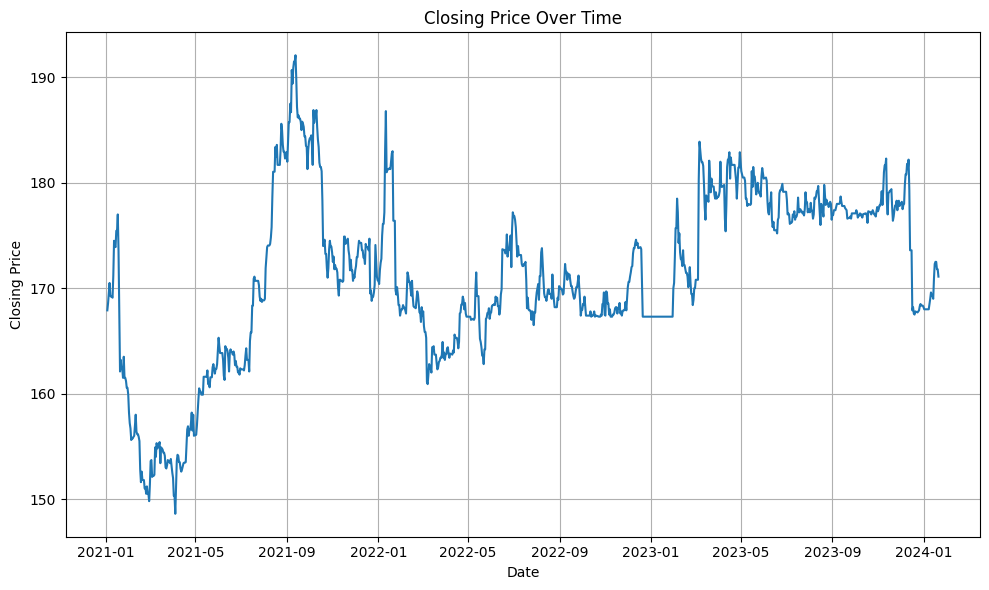

In [53]:
plt.figure(figsize=(10,6))
plt.plot(Data['Date'], Data['Close']) 
plt.title('Closing Price Over Time')  
plt.xlabel('Date')  
plt.ylabel('Closing Price')  
plt.grid(True)  
plt.tight_layout() 
plt.show()

# Add SMA, RSI, MACD

In [54]:
Data.loc[:, 'SMA_7'] = Data['Close'].rolling(window=7).mean()
Data.loc[:, 'SMA_7'].fillna(Data['Close'].iloc[0], inplace=True)

In [57]:
Data['MACD'] = Data['Close'].ewm(span=26, adjust=False).mean() - Data['Close'].ewm(span=12, adjust=False).mean()
Data['Signal_Line'] = Data['MACD'].ewm(span=9, adjust=False).mean()
Data['ema'] = Data['Close'].ewm(span=5, adjust=False).mean()

In [58]:
Data.head()

,Date,Open,High,Low,Close,Volume,day,month,year,1_day,1_week,15_days,1_month,SMA_7,MACD,Signal_Line,ema
0,2021-01-03,166.9,169.0,165.0,167.9,156205.0,3,1,2021,168.6,169.1,173.50,157.20,167.9,0.000000,0.000000,167.900000
1,2021-01-04,167.1,170.0,166.6,168.6,89695.0,4,1,2021,169.6,171.2,167.80,156.70,167.9,-0.055840,-0.011168,168.133333
2,2021-01-05,169.6,173.2,169.1,169.6,98023.0,5,1,2021,170.5,174.5,162.10,155.60,167.9,-0.178726,-0.044680,168.622222
3,2021-01-06,172.0,172.0,168.5,170.5,50243.0,6,1,2021,169.3,174.0,163.20,155.75,167.9,-0.344762,-0.104696,169.248148
4,2021-01-07,171.9,172.0,168.4,169.3,94333.0,7,1,2021,169.2,173.9,162.35,155.75,167.9,-0.375191,-0.158795,169.265432


In [59]:
Dataset = Data.copy()

# Apply Random Forest

1 day ahead prediction

Mean Squared Error: 1.579
Root Mean Squared Error: 1.257
R-squared Score: 0.872


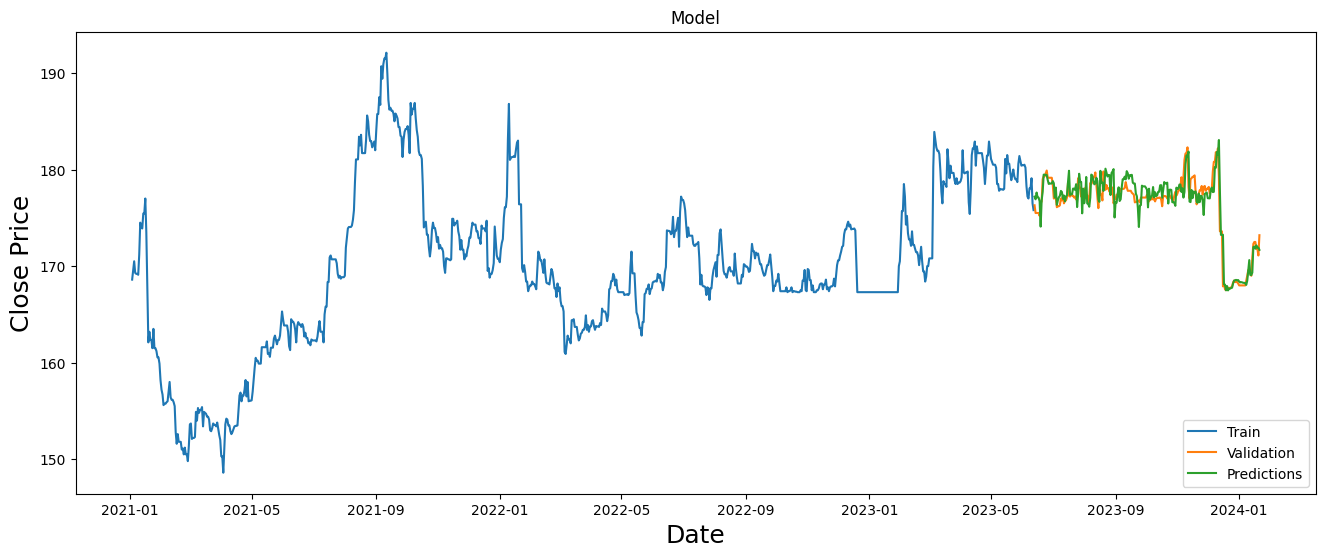

(1.578967434811539, 1.2565697094914945, 0.872458630737365)

In [61]:
RfDF1 = Dataset.copy()
n_estimators = 90
random_state = 15
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
target = '1_day'
run_random_forest(RfDF1, n_estimators, random_state,features, target)

1 week ahead prediction 

Mean Squared Error: 10.261
Root Mean Squared Error: 3.203
R-squared Score: 0.204


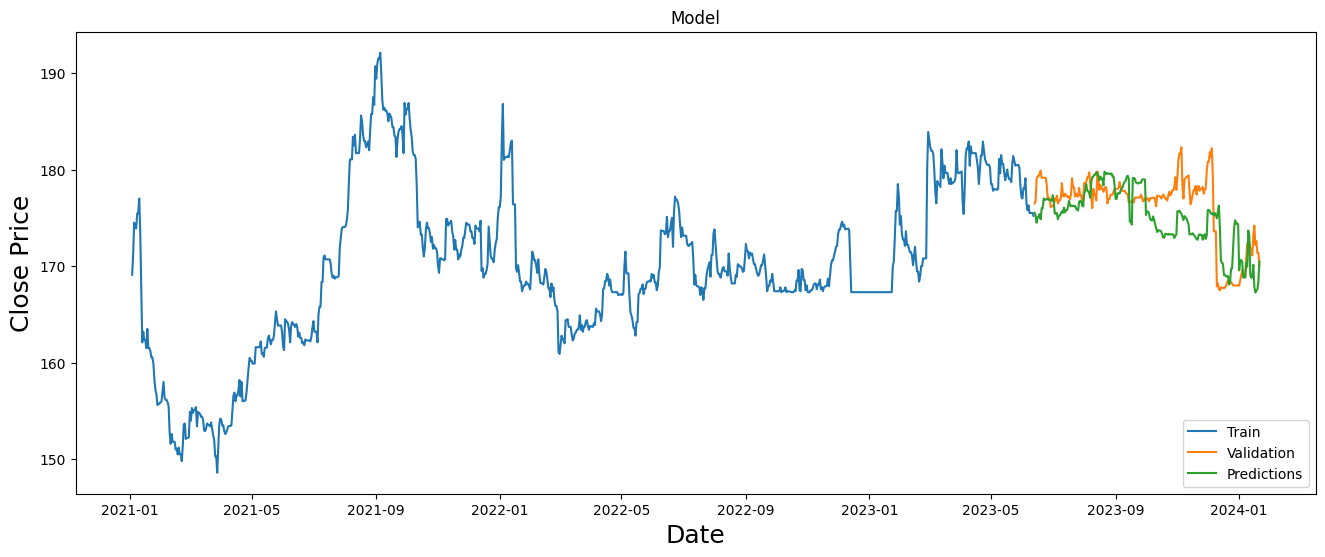

(10.260768908819212, 3.203243498209153, 0.20444545042513573)

In [62]:
RfDF7 = Dataset.copy()
n_estimators = 90
random_state =15
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
target = '1_week'
run_random_forest(RfDF7, n_estimators, random_state,features, target)

15 days ahead prediction 

Mean Squared Error: 14.831
Root Mean Squared Error: 3.851
R-squared Score: -0.127


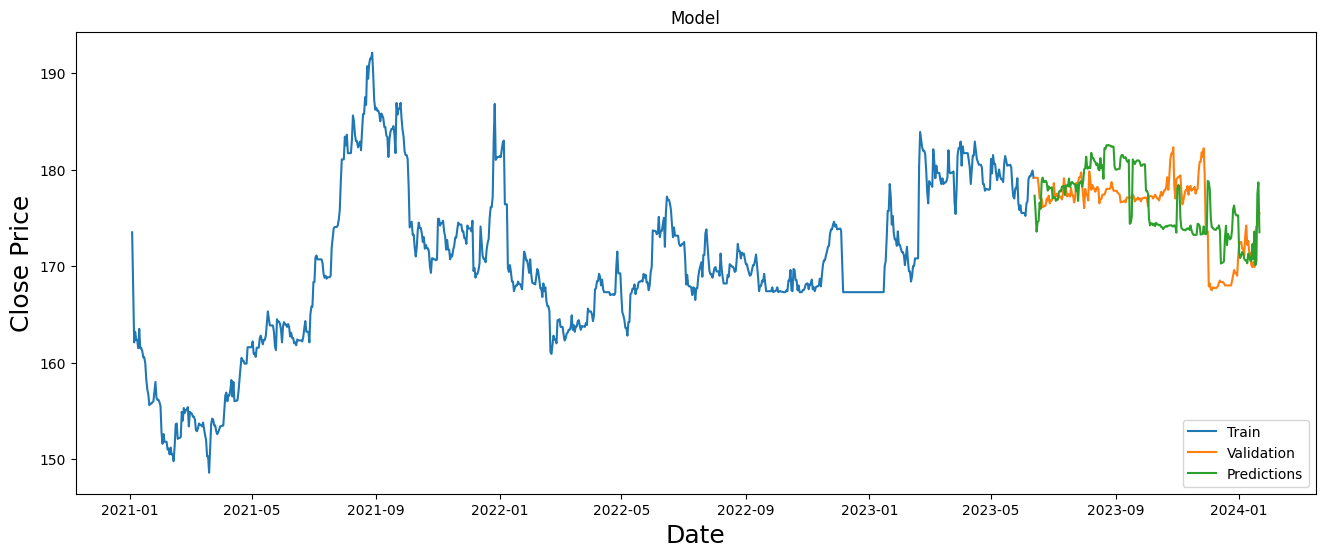

(14.831325465121813, 3.851145993742877, -0.1270323353172642)

In [63]:
RfDF15 = Dataset.copy()
n_estimators = 300
random_state =15
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
target = '15_days'
run_random_forest(RfDF15, n_estimators, random_state,features, target)

# Apply LSTM

1 Day

In [64]:
LDF1 = Dataset.copy()
LDF1.head()


,Date,Open,High,Low,Close,Volume,day,month,year,1_day,1_week,15_days,1_month,SMA_7,MACD,Signal_Line,ema
0,2021-01-03,166.9,169.0,165.0,167.9,156205.0,3,1,2021,168.6,169.1,173.50,157.20,167.9,0.000000,0.000000,167.900000
1,2021-01-04,167.1,170.0,166.6,168.6,89695.0,4,1,2021,169.6,171.2,167.80,156.70,167.9,-0.055840,-0.011168,168.133333
2,2021-01-05,169.6,173.2,169.1,169.6,98023.0,5,1,2021,170.5,174.5,162.10,155.60,167.9,-0.178726,-0.044680,168.622222
3,2021-01-06,172.0,172.0,168.5,170.5,50243.0,6,1,2021,169.3,174.0,163.20,155.75,167.9,-0.344762,-0.104696,169.248148
4,2021-01-07,171.9,172.0,168.4,169.3,94333.0,7,1,2021,169.2,173.9,162.35,155.75,167.9,-0.375191,-0.158795,169.265432


In [66]:
epochs = 120
batch_size = 40
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
target = '1_day'
train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv=LSTM_Model(LDF1,features,target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year']
1_day
120
40
Epoch 1/120
23/23 - 2s - loss: 0.0599 - 2s/epoch - 106ms/step
Epoch 2/120
23/23 - 0s - loss: 0.0101 - 201ms/epoch - 9ms/step
Epoch 3/120
23/23 - 0s - loss: 0.0046 - 169ms/epoch - 7ms/step
Epoch 4/120
23/23 - 0s - loss: 0.0039 - 216ms/epoch - 9ms/step
Epoch 5/120
23/23 - 0s - loss: 0.0036 - 169ms/epoch - 7ms/step
Epoch 6/120
23/23 - 0s - loss: 0.0034 - 169ms/epoch - 7ms/step
Epoch 7/120
23/23 - 0s - loss: 0.0032 - 185ms/epoch - 8ms/step
Epoch 8/120
23/23 - 0s - loss: 0.0032 - 201ms/epoch - 9ms/step
Epoch 9/120
23/23 - 0s - loss: 0.0032 - 178ms/epoch - 8ms/step
Epoch 10/120
23/23 - 0s - loss: 0.0029 - 169ms/epoch - 7ms/step
Epoch 11/120
23/23 - 0s - loss: 0.0027 - 169ms/epoch - 7ms/step
Epoch 12/120
23/23 - 0s - loss: 0.0027 - 169ms/epoch - 7ms/step
Epoch 13/120
23/23 - 0s - loss: 0.0027 - 178ms/epoch - 8ms/step
Epoch 14/120
23/23 - 0s - loss: 0.0025 - 169ms/epoch - 7ms/step
Epoch 15/120
23/23 - 0s - loss: 0.

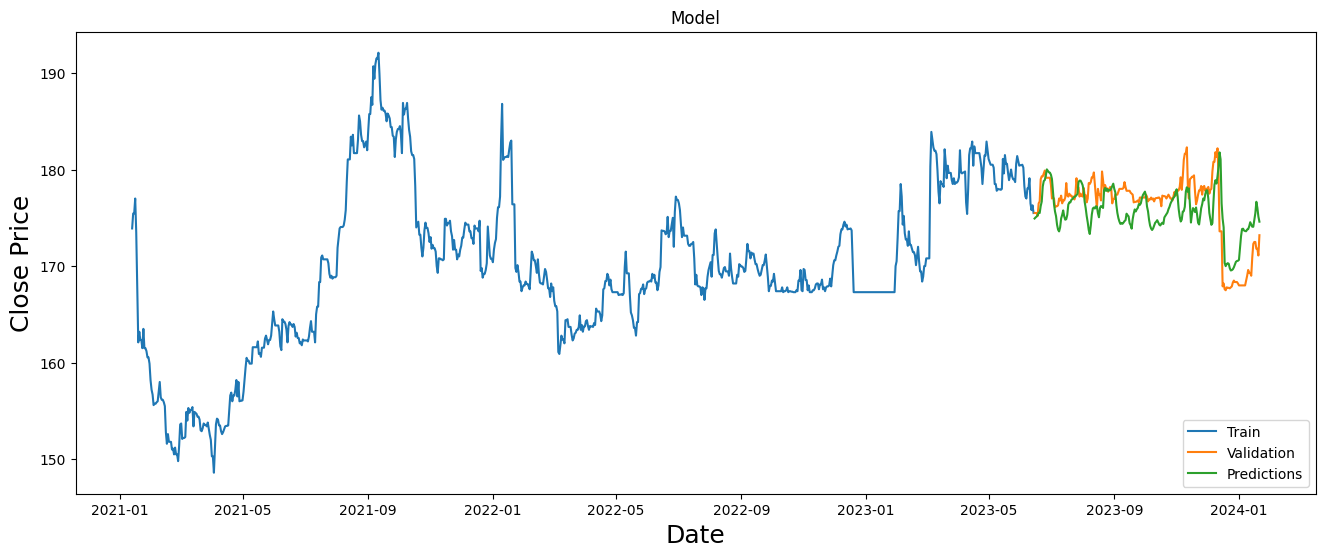

In [67]:
linegraph(train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv)

1 week

In [70]:
LDF7 = Dataset.copy()
LDF7.head()

,Date,Open,High,Low,Close,Volume,day,month,year,1_day,1_week,15_days,1_month,SMA_7,MACD,Signal_Line,ema
0,2021-01-03,166.9,169.0,165.0,167.9,156205.0,3,1,2021,168.6,169.1,173.50,157.20,167.9,0.000000,0.000000,167.900000
1,2021-01-04,167.1,170.0,166.6,168.6,89695.0,4,1,2021,169.6,171.2,167.80,156.70,167.9,-0.055840,-0.011168,168.133333
2,2021-01-05,169.6,173.2,169.1,169.6,98023.0,5,1,2021,170.5,174.5,162.10,155.60,167.9,-0.178726,-0.044680,168.622222
3,2021-01-06,172.0,172.0,168.5,170.5,50243.0,6,1,2021,169.3,174.0,163.20,155.75,167.9,-0.344762,-0.104696,169.248148
4,2021-01-07,171.9,172.0,168.4,169.3,94333.0,7,1,2021,169.2,173.9,162.35,155.75,167.9,-0.375191,-0.158795,169.265432


In [71]:
epochs = 120
batch_size = 40
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
target = '1_week'
train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv=LSTM_Model(LDF7,features,target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year']
1_week
120
40
Epoch 1/120
23/23 - 3s - loss: 0.0813 - 3s/epoch - 123ms/step
Epoch 2/120
23/23 - 0s - loss: 0.0124 - 185ms/epoch - 8ms/step
Epoch 3/120
23/23 - 0s - loss: 0.0086 - 185ms/epoch - 8ms/step
Epoch 4/120
23/23 - 0s - loss: 0.0076 - 178ms/epoch - 8ms/step
Epoch 5/120
23/23 - 0s - loss: 0.0072 - 185ms/epoch - 8ms/step
Epoch 6/120
23/23 - 0s - loss: 0.0067 - 201ms/epoch - 9ms/step
Epoch 7/120
23/23 - 0s - loss: 0.0065 - 185ms/epoch - 8ms/step
Epoch 8/120
23/23 - 0s - loss: 0.0060 - 185ms/epoch - 8ms/step
Epoch 9/120
23/23 - 0s - loss: 0.0057 - 185ms/epoch - 8ms/step
Epoch 10/120
23/23 - 0s - loss: 0.0055 - 169ms/epoch - 7ms/step
Epoch 11/120
23/23 - 0s - loss: 0.0053 - 169ms/epoch - 7ms/step
Epoch 12/120
23/23 - 0s - loss: 0.0055 - 178ms/epoch - 8ms/step
Epoch 13/120
23/23 - 0s - loss: 0.0052 - 169ms/epoch - 7ms/step
Epoch 14/120
23/23 - 0s - loss: 0.0051 - 185ms/epoch - 8ms/step
Epoch 15/120
23/23 - 0s - loss: 0

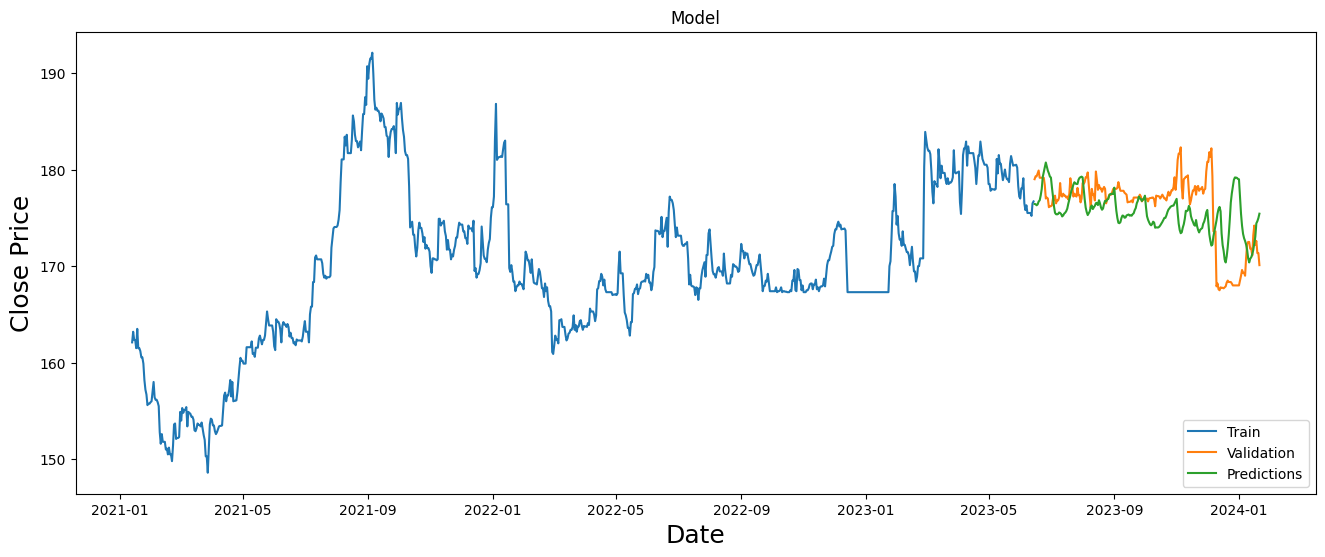

In [72]:
linegraph(train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv)

15 days

In [77]:
LDF15 = Dataset.copy()
epochs = 170
batch_size = 40
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
target = '15_days'
train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv=LSTM_Model(LDF15,features,target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year']
15_days
170
40
Epoch 1/170
23/23 - 2s - loss: 0.0814 - 2s/epoch - 105ms/step
Epoch 2/170
23/23 - 0s - loss: 0.0143 - 181ms/epoch - 8ms/step
Epoch 3/170
23/23 - 0s - loss: 0.0115 - 183ms/epoch - 8ms/step
Epoch 4/170
23/23 - 0s - loss: 0.0110 - 179ms/epoch - 8ms/step
Epoch 5/170
23/23 - 0s - loss: 0.0105 - 181ms/epoch - 8ms/step
Epoch 6/170
23/23 - 0s - loss: 0.0098 - 183ms/epoch - 8ms/step
Epoch 7/170
23/23 - 0s - loss: 0.0092 - 178ms/epoch - 8ms/step
Epoch 8/170
23/23 - 0s - loss: 0.0088 - 181ms/epoch - 8ms/step
Epoch 9/170
23/23 - 0s - loss: 0.0080 - 181ms/epoch - 8ms/step
Epoch 10/170
23/23 - 0s - loss: 0.0071 - 188ms/epoch - 8ms/step
Epoch 11/170
23/23 - 0s - loss: 0.0067 - 182ms/epoch - 8ms/step
Epoch 12/170
23/23 - 0s - loss: 0.0064 - 180ms/epoch - 8ms/step
Epoch 13/170
23/23 - 0s - loss: 0.0063 - 177ms/epoch - 8ms/step
Epoch 14/170
23/23 - 0s - loss: 0.0062 - 176ms/epoch - 8ms/step
Epoch 15/170
23/23 - 0s - loss: 

Epoch 128/170
23/23 - 0s - loss: 0.0018 - 172ms/epoch - 7ms/step
Epoch 129/170
23/23 - 0s - loss: 0.0017 - 174ms/epoch - 8ms/step
Epoch 130/170
23/23 - 0s - loss: 0.0015 - 171ms/epoch - 7ms/step
Epoch 131/170
23/23 - 0s - loss: 0.0015 - 173ms/epoch - 8ms/step
Epoch 132/170
23/23 - 0s - loss: 0.0015 - 169ms/epoch - 7ms/step
Epoch 133/170
23/23 - 0s - loss: 0.0015 - 171ms/epoch - 7ms/step
Epoch 134/170
23/23 - 0s - loss: 0.0013 - 171ms/epoch - 7ms/step
Epoch 135/170
23/23 - 0s - loss: 0.0021 - 171ms/epoch - 7ms/step
Epoch 136/170
23/23 - 0s - loss: 0.0016 - 175ms/epoch - 8ms/step
Epoch 137/170
23/23 - 0s - loss: 0.0014 - 171ms/epoch - 7ms/step
Epoch 138/170
23/23 - 0s - loss: 0.0014 - 171ms/epoch - 7ms/step
Epoch 139/170
23/23 - 0s - loss: 0.0015 - 170ms/epoch - 7ms/step
Epoch 140/170
23/23 - 0s - loss: 0.0024 - 173ms/epoch - 8ms/step
Epoch 141/170
23/23 - 0s - loss: 0.0017 - 167ms/epoch - 7ms/step
Epoch 142/170
23/23 - 0s - loss: 0.0014 - 176ms/epoch - 8ms/step
Epoch 143/170
23/23 - 0s 

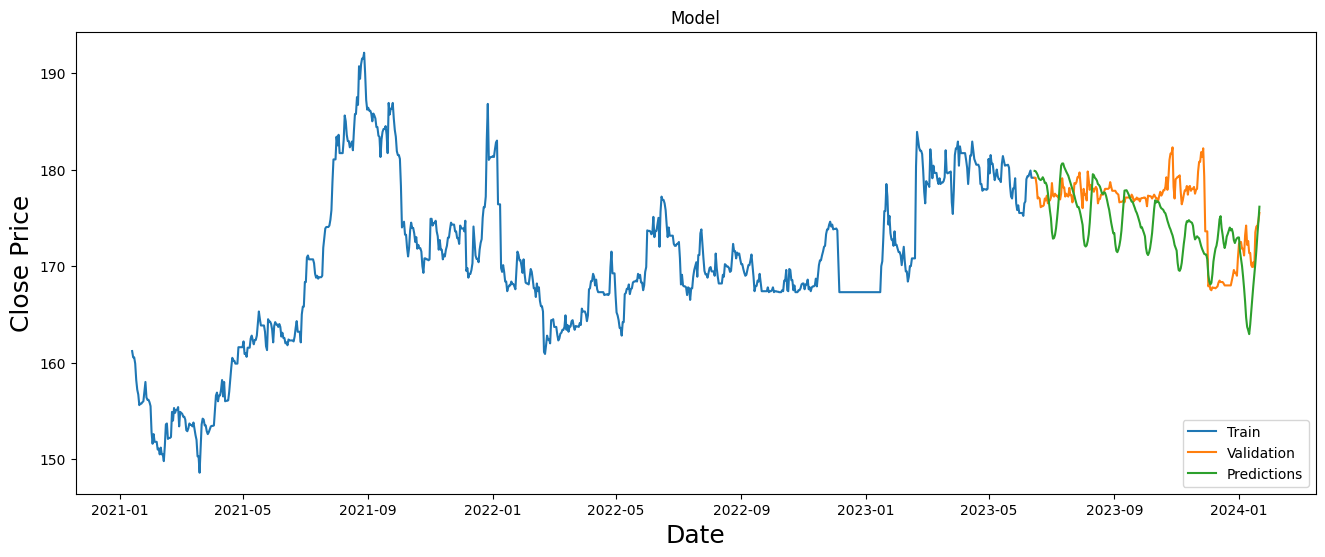

In [78]:
linegraph(train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv)

# Apply GRU

1 day

In [79]:
GDF1 = Dataset.copy()
epochs = 80
batch_size = 30
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
Target = '1_day'
GRU_Model(GDF1,Features, Target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year']
1_day
80
30
Epoch 1/80
30/30 [==============================] - 8s 15ms/step - loss: 0.0170
Epoch 2/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0034
Epoch 3/80
30/30 [==============================] - 1s 17ms/step - loss: 0.0029
Epoch 4/80
30/30 [==============================] - 1s 18ms/step - loss: 0.0027
Epoch 5/80
30/30 [==============================] - 1s 18ms/step - loss: 0.0027
Epoch 6/80
30/30 [==============================] - 1s 17ms/step - loss: 0.0026
Epoch 7/80
30/30 [==============================] - 1s 18ms/step - loss: 0.0025
Epoch 8/80
30/30 [==============================] - 1s 19ms/step - loss: 0.0025
Epoch 9/80
30/30 [==============================] - 1s 18ms/step - loss: 0.0023
Epoch 10/80
30/30 [==============================] - 1s 18ms/step - loss: 0.0025
Epoch 11/80
30/30 [==============================] - 1s 18ms/step - loss: 0.0023
Epoch 12/80
30/30 [====================

1 week

In [83]:
GDF7 = Dataset.copy()
epochs = 80
batch_size = 30
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
Target = '1_week'
GRU_Model(GDF7,Features, Target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year']
1_week
80
30
Epoch 1/80
30/30 [==============================] - 7s 16ms/step - loss: 0.0368
Epoch 2/80
30/30 [==============================] - 1s 17ms/step - loss: 0.0090
Epoch 3/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0072
Epoch 4/80
30/30 [==============================] - 1s 16ms/step - loss: 0.0070
Epoch 5/80
30/30 [==============================] - 0s 15ms/step - loss: 0.0071
Epoch 6/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0066
Epoch 7/80
30/30 [==============================] - 0s 15ms/step - loss: 0.0065
Epoch 8/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0064
Epoch 9/80
30/30 [==============================] - 0s 15ms/step - loss: 0.0063
Epoch 10/80
30/30 [==============================] - 0s 15ms/step - loss: 0.0064
Epoch 11/80
30/30 [==============================] - 0s 15ms/step - loss: 0.0062
Epoch 12/80
30/30 [===================

15 days

In [84]:
GDF15 = Dataset.copy()
epochs = 80
batch_size = 30
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
Target = '15_days'
GRU_Model(GDF15,Features, Target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year']
15_days
80
30
Epoch 1/80
30/30 [==============================] - 7s 16ms/step - loss: 0.0229
Epoch 2/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0120
Epoch 3/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0110
Epoch 4/80
30/30 [==============================] - 1s 17ms/step - loss: 0.0107
Epoch 5/80
30/30 [==============================] - 1s 18ms/step - loss: 0.0108
Epoch 6/80
30/30 [==============================] - 1s 17ms/step - loss: 0.0107
Epoch 7/80
30/30 [==============================] - 1s 17ms/step - loss: 0.0103
Epoch 8/80
30/30 [==============================] - 1s 17ms/step - loss: 0.0103
Epoch 9/80
30/30 [==============================] - 1s 17ms/step - loss: 0.0108
Epoch 10/80
30/30 [==============================] - 1s 18ms/step - loss: 0.0089
Epoch 11/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0079
Epoch 12/80
30/30 [==================

1 month

# Apply XGboost

1 day

In [85]:
Dataset.head()

,Date,Open,High,Low,Close,Volume,day,month,year,1_day,1_week,15_days,1_month,SMA_7,MACD,Signal_Line,ema
0,2021-01-03,166.9,169.0,165.0,167.9,156205.0,3,1,2021,168.6,169.1,173.50,157.20,167.9,0.000000,0.000000,167.900000
1,2021-01-04,167.1,170.0,166.6,168.6,89695.0,4,1,2021,169.6,171.2,167.80,156.70,167.9,-0.055840,-0.011168,168.133333
2,2021-01-05,169.6,173.2,169.1,169.6,98023.0,5,1,2021,170.5,174.5,162.10,155.60,167.9,-0.178726,-0.044680,168.622222
3,2021-01-06,172.0,172.0,168.5,170.5,50243.0,6,1,2021,169.3,174.0,163.20,155.75,167.9,-0.344762,-0.104696,169.248148
4,2021-01-07,171.9,172.0,168.4,169.3,94333.0,7,1,2021,169.2,173.9,162.35,155.75,167.9,-0.375191,-0.158795,169.265432


Mean Squared Error: 1.9824942396537766
Root Mean Squared Error: 1.4080107384724652
R-squared: 0.8398636828688562


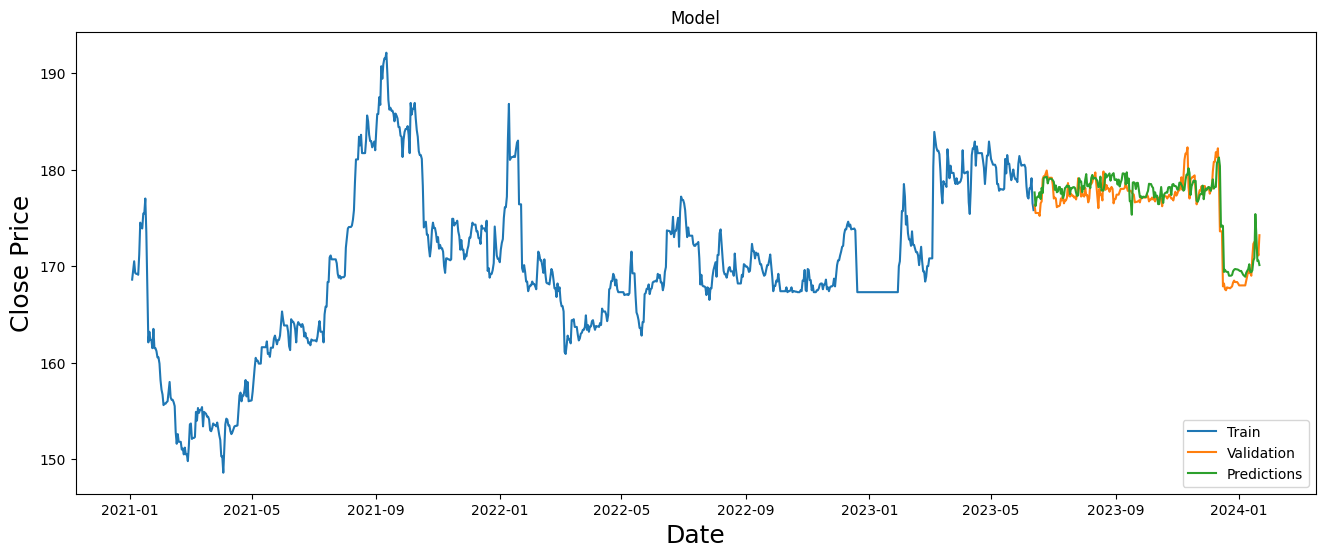

In [86]:
XDF1 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
Target = '1_day'
run_xgboost(XDF1, Features, Target, random_state)

1 week

Mean Squared Error: 8.759451581235986
Root Mean Squared Error: 2.959637069175203
R-squared: 0.3208480164441242


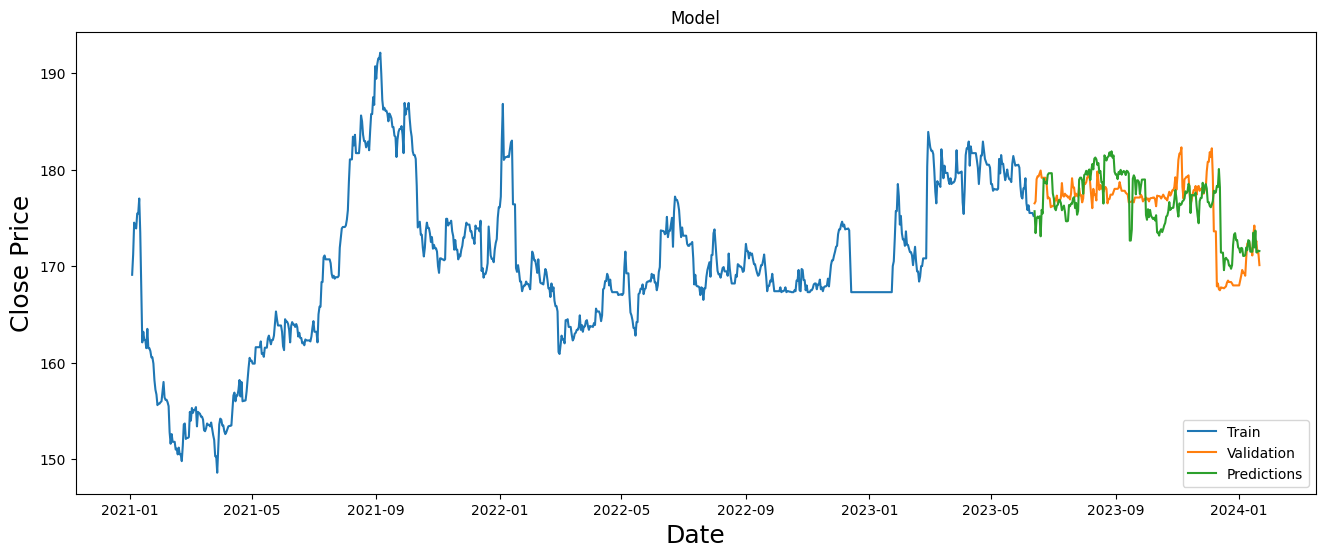

In [87]:
XDF7 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
Target = '1_week'
run_xgboost(XDF7, Features, Target, random_state)

15 days

Mean Squared Error: 15.644975921505216
Root Mean Squared Error: 3.9553730445439927
R-squared: -0.1888616287372109


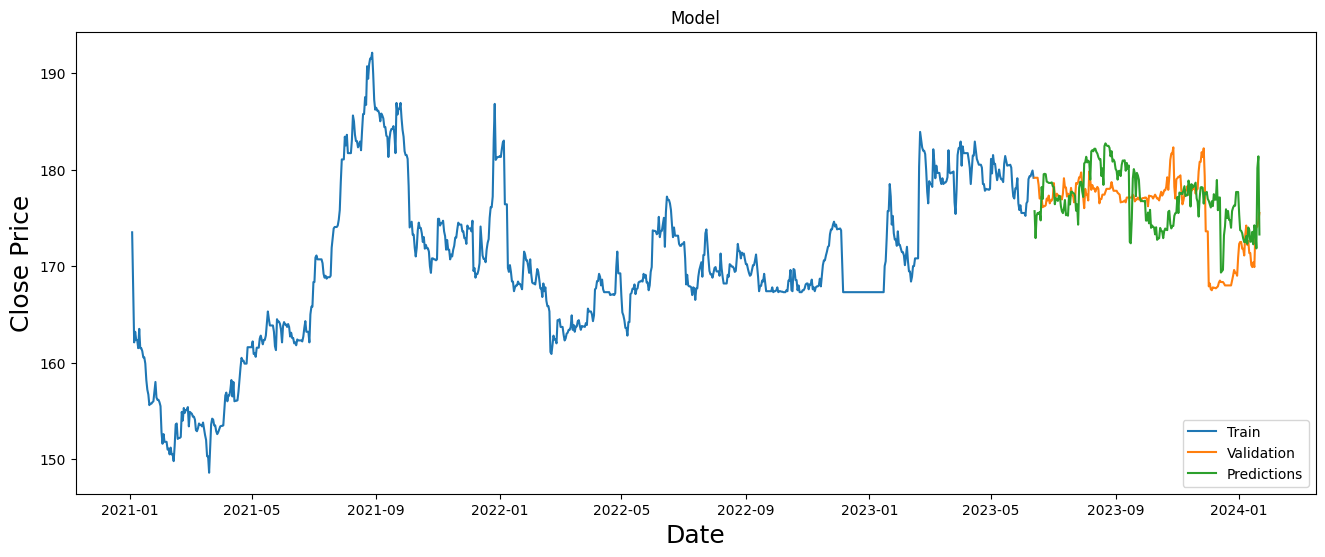

In [88]:
XDF15 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
Target = '15_days'
run_xgboost(XDF15, Features, Target, random_state)

1 month

#  EMA

# Apply Random Forest

In [89]:
Dataset.head()

,Date,Open,High,Low,Close,Volume,day,month,year,1_day,1_week,15_days,1_month,SMA_7,MACD,Signal_Line,ema
0,2021-01-03,166.9,169.0,165.0,167.9,156205.0,3,1,2021,168.6,169.1,173.50,157.20,167.9,0.000000,0.000000,167.900000
1,2021-01-04,167.1,170.0,166.6,168.6,89695.0,4,1,2021,169.6,171.2,167.80,156.70,167.9,-0.055840,-0.011168,168.133333
2,2021-01-05,169.6,173.2,169.1,169.6,98023.0,5,1,2021,170.5,174.5,162.10,155.60,167.9,-0.178726,-0.044680,168.622222
3,2021-01-06,172.0,172.0,168.5,170.5,50243.0,6,1,2021,169.3,174.0,163.20,155.75,167.9,-0.344762,-0.104696,169.248148
4,2021-01-07,171.9,172.0,168.4,169.3,94333.0,7,1,2021,169.2,173.9,162.35,155.75,167.9,-0.375191,-0.158795,169.265432


Mean Squared Error: 1.471
Root Mean Squared Error: 1.213
R-squared Score: 0.881


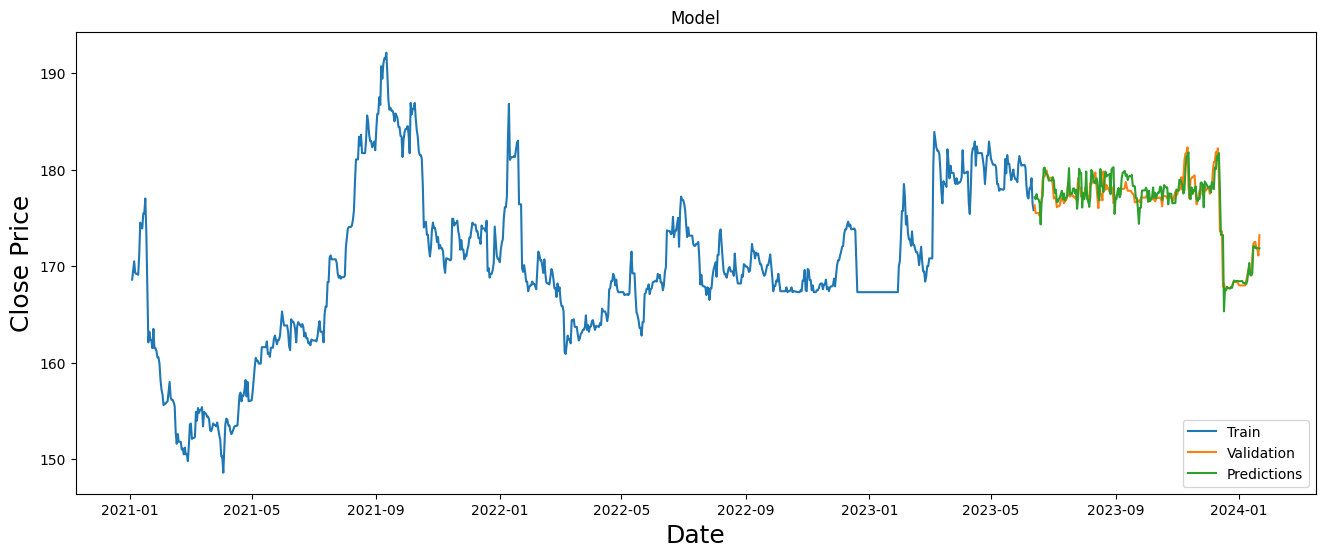

(1.470690485799614, 1.2127202834123019, 0.8812047201323053)

In [90]:
RfDF1 = Dataset.copy()
n_estimators = 150
random_state = 15
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
target = '1_day'
run_random_forest(RfDF1, n_estimators, random_state,features, target)


Mean Squared Error: 10.270
Root Mean Squared Error: 3.205
R-squared Score: 0.204


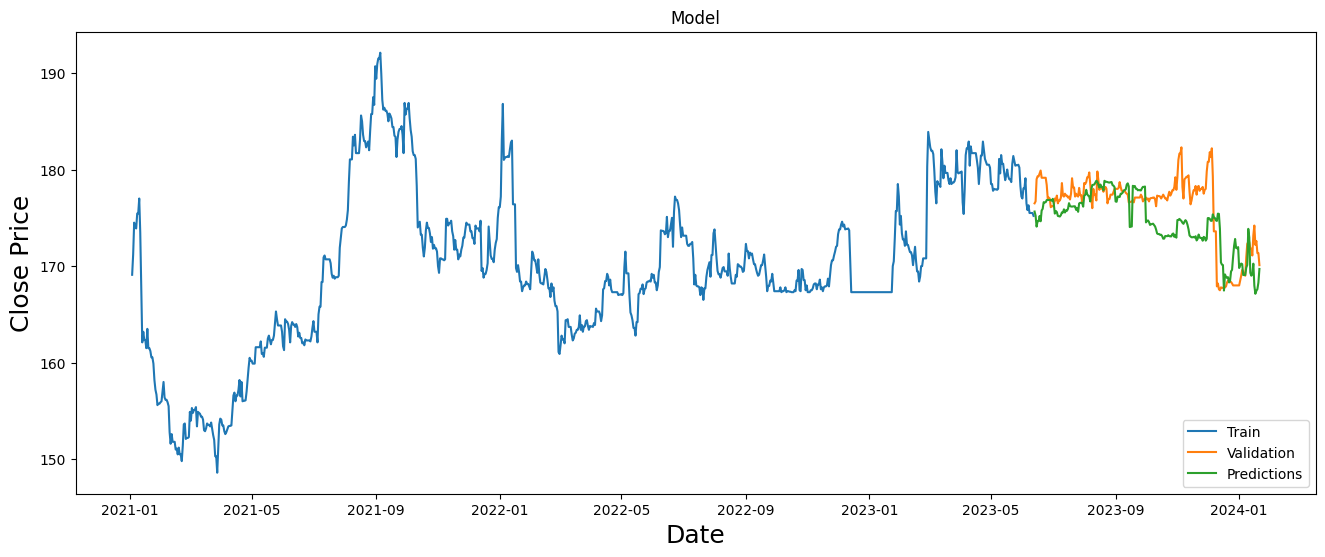

(10.2698366243146, 3.2046585815519566, 0.20374239762463797)

In [91]:
RfDF7 = Dataset.copy()
n_estimators = 150
random_state =15
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
target = '1_week'
run_random_forest(RfDF7, n_estimators, random_state,features, target)

Mean Squared Error: 13.942
Root Mean Squared Error: 3.734
R-squared Score: -0.059


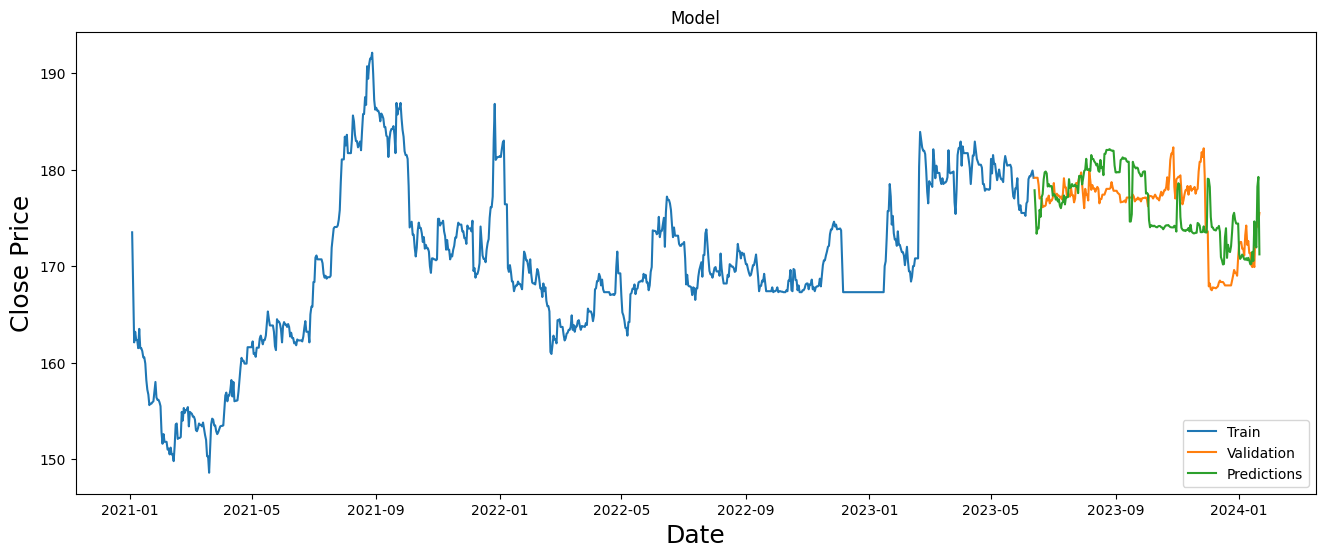

(13.94209577478801, 3.7339115917209407, -0.059459776351636906)

In [92]:
RfDF15 = Dataset.copy()
n_estimators = 150
random_state =15
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
target = '15_days'
run_random_forest(RfDF15, n_estimators, random_state,features, target)

# Apply LSTM

In [93]:
LDF1 = Dataset.copy()
epochs = 90
batch_size = 40
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
target = '1_day'
train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv=LSTM_Model(LDF1,features,target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'ema']
1_day
90
40
Epoch 1/90
23/23 - 3s - loss: 0.0227 - 3s/epoch - 116ms/step
Epoch 2/90
23/23 - 0s - loss: 0.0062 - 201ms/epoch - 9ms/step
Epoch 3/90
23/23 - 0s - loss: 0.0042 - 185ms/epoch - 8ms/step
Epoch 4/90
23/23 - 0s - loss: 0.0035 - 185ms/epoch - 8ms/step
Epoch 5/90
23/23 - 0s - loss: 0.0034 - 201ms/epoch - 9ms/step
Epoch 6/90
23/23 - 0s - loss: 0.0032 - 185ms/epoch - 8ms/step
Epoch 7/90
23/23 - 0s - loss: 0.0031 - 185ms/epoch - 8ms/step
Epoch 8/90
23/23 - 0s - loss: 0.0030 - 185ms/epoch - 8ms/step
Epoch 9/90
23/23 - 0s - loss: 0.0029 - 185ms/epoch - 8ms/step
Epoch 10/90
23/23 - 0s - loss: 0.0032 - 178ms/epoch - 8ms/step
Epoch 11/90
23/23 - 0s - loss: 0.0029 - 185ms/epoch - 8ms/step
Epoch 12/90
23/23 - 0s - loss: 0.0026 - 185ms/epoch - 8ms/step
Epoch 13/90
23/23 - 0s - loss: 0.0026 - 201ms/epoch - 9ms/step
Epoch 14/90
23/23 - 0s - loss: 0.0026 - 185ms/epoch - 8ms/step
Epoch 15/90
23/23 - 0s - loss: 0.0026 - 18

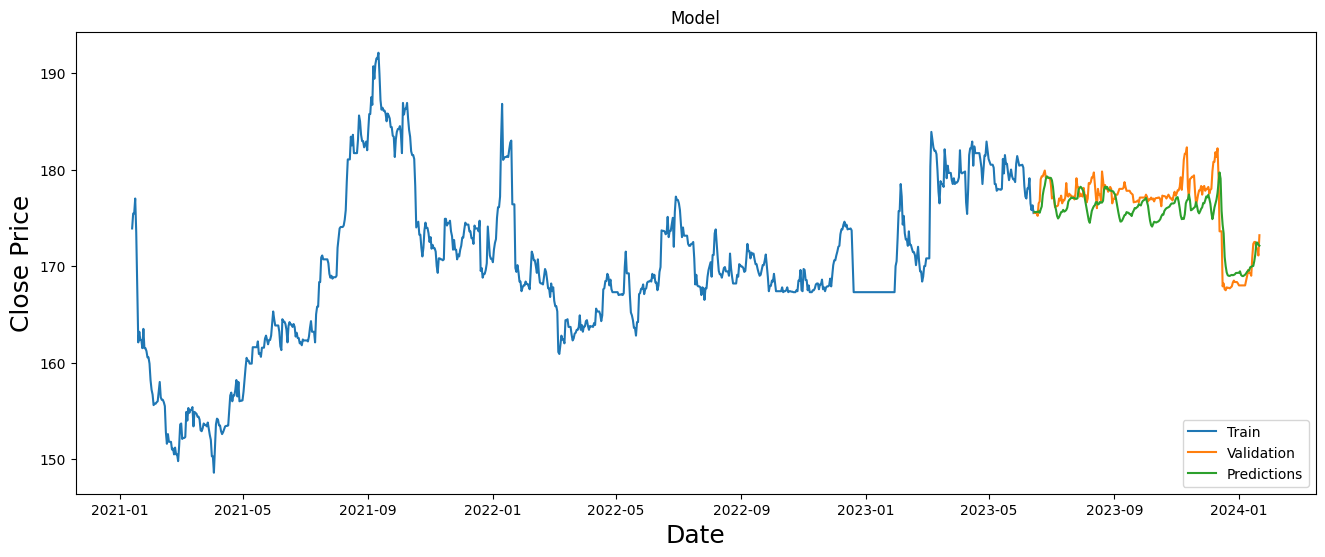

In [94]:
linegraph(train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv)


In [95]:
LDF7 = Dataset.copy()
epochs = 120
batch_size = 40
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
target = '1_week'
train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv=LSTM_Model(LDF7,features,target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'ema']
1_week
120
40
Epoch 1/120
23/23 - 2s - loss: 0.0196 - 2s/epoch - 107ms/step
Epoch 2/120
23/23 - 0s - loss: 0.0073 - 185ms/epoch - 8ms/step
Epoch 3/120
23/23 - 0s - loss: 0.0066 - 201ms/epoch - 9ms/step
Epoch 4/120
23/23 - 0s - loss: 0.0063 - 178ms/epoch - 8ms/step
Epoch 5/120
23/23 - 0s - loss: 0.0059 - 178ms/epoch - 8ms/step
Epoch 6/120
23/23 - 0s - loss: 0.0058 - 185ms/epoch - 8ms/step
Epoch 7/120
23/23 - 0s - loss: 0.0051 - 185ms/epoch - 8ms/step
Epoch 8/120
23/23 - 0s - loss: 0.0049 - 169ms/epoch - 7ms/step
Epoch 9/120
23/23 - 0s - loss: 0.0049 - 185ms/epoch - 8ms/step
Epoch 10/120
23/23 - 0s - loss: 0.0046 - 178ms/epoch - 8ms/step
Epoch 11/120
23/23 - 0s - loss: 0.0045 - 185ms/epoch - 8ms/step
Epoch 12/120
23/23 - 0s - loss: 0.0047 - 185ms/epoch - 8ms/step
Epoch 13/120
23/23 - 0s - loss: 0.0042 - 185ms/epoch - 8ms/step
Epoch 14/120
23/23 - 0s - loss: 0.0044 - 185ms/epoch - 8ms/step
Epoch 15/120
23/23 - 0s - 

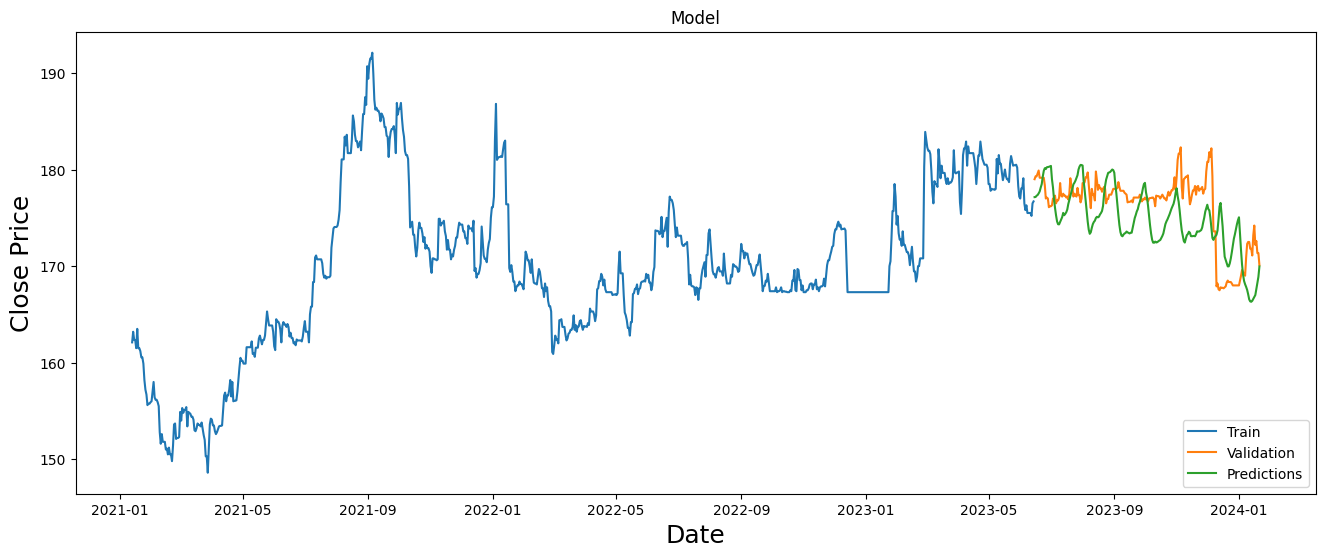

In [96]:
linegraph(train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv)

In [99]:
LDF15 = Dataset.copy()
epochs = 190
batch_size = 40
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
target = '15_days'
train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv=LSTM_Model(LDF15,features,target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'ema']
15_days
190
40
Epoch 1/190
23/23 - 2s - loss: 0.0457 - 2s/epoch - 107ms/step
Epoch 2/190
23/23 - 0s - loss: 0.0147 - 185ms/epoch - 8ms/step
Epoch 3/190
23/23 - 0s - loss: 0.0117 - 185ms/epoch - 8ms/step
Epoch 4/190
23/23 - 0s - loss: 0.0107 - 178ms/epoch - 8ms/step
Epoch 5/190
23/23 - 0s - loss: 0.0095 - 169ms/epoch - 7ms/step
Epoch 6/190
23/23 - 0s - loss: 0.0087 - 185ms/epoch - 8ms/step
Epoch 7/190
23/23 - 0s - loss: 0.0077 - 185ms/epoch - 8ms/step
Epoch 8/190
23/23 - 0s - loss: 0.0069 - 185ms/epoch - 8ms/step
Epoch 9/190
23/23 - 0s - loss: 0.0074 - 178ms/epoch - 8ms/step
Epoch 10/190
23/23 - 0s - loss: 0.0070 - 169ms/epoch - 7ms/step
Epoch 11/190
23/23 - 0s - loss: 0.0062 - 185ms/epoch - 8ms/step
Epoch 12/190
23/23 - 0s - loss: 0.0059 - 185ms/epoch - 8ms/step
Epoch 13/190
23/23 - 0s - loss: 0.0067 - 169ms/epoch - 7ms/step
Epoch 14/190
23/23 - 0s - loss: 0.0054 - 178ms/epoch - 8ms/step
Epoch 15/190
23/23 - 0s -

Epoch 128/190
23/23 - 0s - loss: 0.0016 - 169ms/epoch - 7ms/step
Epoch 129/190
23/23 - 0s - loss: 0.0013 - 169ms/epoch - 7ms/step
Epoch 130/190
23/23 - 0s - loss: 0.0012 - 178ms/epoch - 8ms/step
Epoch 131/190
23/23 - 0s - loss: 0.0014 - 185ms/epoch - 8ms/step
Epoch 132/190
23/23 - 0s - loss: 0.0014 - 169ms/epoch - 7ms/step
Epoch 133/190
23/23 - 0s - loss: 0.0013 - 185ms/epoch - 8ms/step
Epoch 134/190
23/23 - 0s - loss: 0.0012 - 178ms/epoch - 8ms/step
Epoch 135/190
23/23 - 0s - loss: 0.0012 - 169ms/epoch - 7ms/step
Epoch 136/190
23/23 - 0s - loss: 0.0011 - 169ms/epoch - 7ms/step
Epoch 137/190
23/23 - 0s - loss: 0.0012 - 185ms/epoch - 8ms/step
Epoch 138/190
23/23 - 0s - loss: 0.0012 - 163ms/epoch - 7ms/step
Epoch 139/190
23/23 - 0s - loss: 0.0014 - 169ms/epoch - 7ms/step
Epoch 140/190
23/23 - 0s - loss: 0.0012 - 185ms/epoch - 8ms/step
Epoch 141/190
23/23 - 0s - loss: 0.0013 - 169ms/epoch - 7ms/step
Epoch 142/190
23/23 - 0s - loss: 0.0011 - 178ms/epoch - 8ms/step
Epoch 143/190
23/23 - 0s 

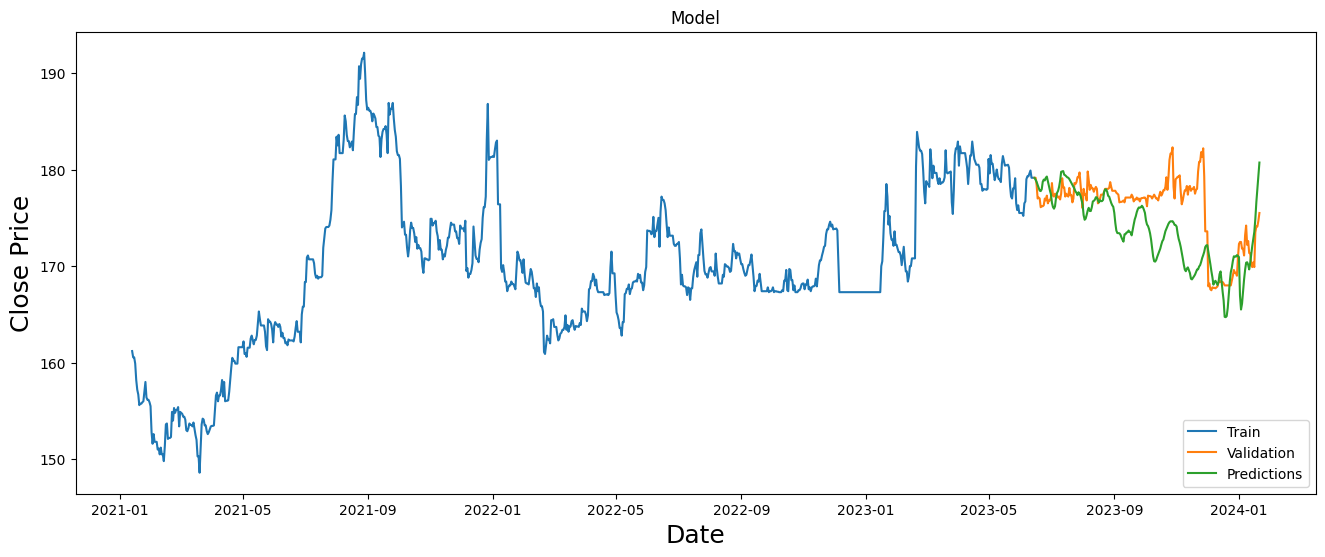

In [100]:
linegraph(train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv)

# GRU

In [101]:
GDF1 = Dataset.copy()
epochs = 90
batch_size = 30
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
Target = '1_day'
GRU_Model(GDF1,Features, Target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'ema']
1_day
90
30
Epoch 1/90
30/30 [==============================] - 7s 14ms/step - loss: 0.0175
Epoch 2/90
30/30 [==============================] - 0s 15ms/step - loss: 0.0035
Epoch 3/90
30/30 [==============================] - 0s 15ms/step - loss: 0.0029
Epoch 4/90
30/30 [==============================] - 0s 16ms/step - loss: 0.0028
Epoch 5/90
30/30 [==============================] - 0s 15ms/step - loss: 0.0026
Epoch 6/90
30/30 [==============================] - 0s 15ms/step - loss: 0.0026
Epoch 7/90
30/30 [==============================] - 0s 15ms/step - loss: 0.0025
Epoch 8/90
30/30 [==============================] - 0s 15ms/step - loss: 0.0025
Epoch 9/90
30/30 [==============================] - 0s 15ms/step - loss: 0.0023
Epoch 10/90
30/30 [==============================] - 0s 15ms/step - loss: 0.0024
Epoch 11/90
30/30 [==============================] - 0s 15ms/step - loss: 0.0022
Epoch 12/90
30/30 [=============

In [102]:
GDF7 = Dataset.copy()
epochs = 90
batch_size = 30
Features =  ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
Target = '1_week'
GRU_Model(GDF7,Features, Target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'ema']
1_week
90
30
Epoch 1/90
30/30 [==============================] - 7s 15ms/step - loss: 0.0286
Epoch 2/90
30/30 [==============================] - 0s 16ms/step - loss: 0.0081
Epoch 3/90
30/30 [==============================] - 0s 15ms/step - loss: 0.0073
Epoch 4/90
30/30 [==============================] - 0s 15ms/step - loss: 0.0070
Epoch 5/90
30/30 [==============================] - 0s 16ms/step - loss: 0.0068
Epoch 6/90
30/30 [==============================] - 0s 15ms/step - loss: 0.0066
Epoch 7/90
30/30 [==============================] - 0s 15ms/step - loss: 0.0065
Epoch 8/90
30/30 [==============================] - 0s 16ms/step - loss: 0.0066
Epoch 9/90
30/30 [==============================] - 0s 15ms/step - loss: 0.0062
Epoch 10/90
30/30 [==============================] - 0s 16ms/step - loss: 0.0061
Epoch 11/90
30/30 [==============================] - 0s 15ms/step - loss: 0.0059
Epoch 12/90
30/30 [============

In [107]:
GDF15 = Dataset.copy()
epochs = 90
batch_size = 40
Features =  ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
Target = '15_days'
GRU_Model(GDF15,Features, Target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'ema']
15_days
90
40
Epoch 1/90
23/23 [==============================] - 7s 16ms/step - loss: 0.1772
Epoch 2/90
23/23 [==============================] - 0s 18ms/step - loss: 0.0159
Epoch 3/90
23/23 [==============================] - 0s 17ms/step - loss: 0.0127
Epoch 4/90
23/23 [==============================] - 0s 17ms/step - loss: 0.0119
Epoch 5/90
23/23 [==============================] - 0s 17ms/step - loss: 0.0115
Epoch 6/90
23/23 [==============================] - 0s 17ms/step - loss: 0.0114
Epoch 7/90
23/23 [==============================] - 0s 16ms/step - loss: 0.0111
Epoch 8/90
23/23 [==============================] - 0s 17ms/step - loss: 0.0109
Epoch 9/90
23/23 [==============================] - 0s 17ms/step - loss: 0.0110
Epoch 10/90
23/23 [==============================] - 0s 18ms/step - loss: 0.0108
Epoch 11/90
23/23 [==============================] - 0s 17ms/step - loss: 0.0107
Epoch 12/90
23/23 [===========

# XGBoost

Mean Squared Error: 1.5768622952206026
Root Mean Squared Error: 1.2557317767822087
R-squared: 0.8726286737540844


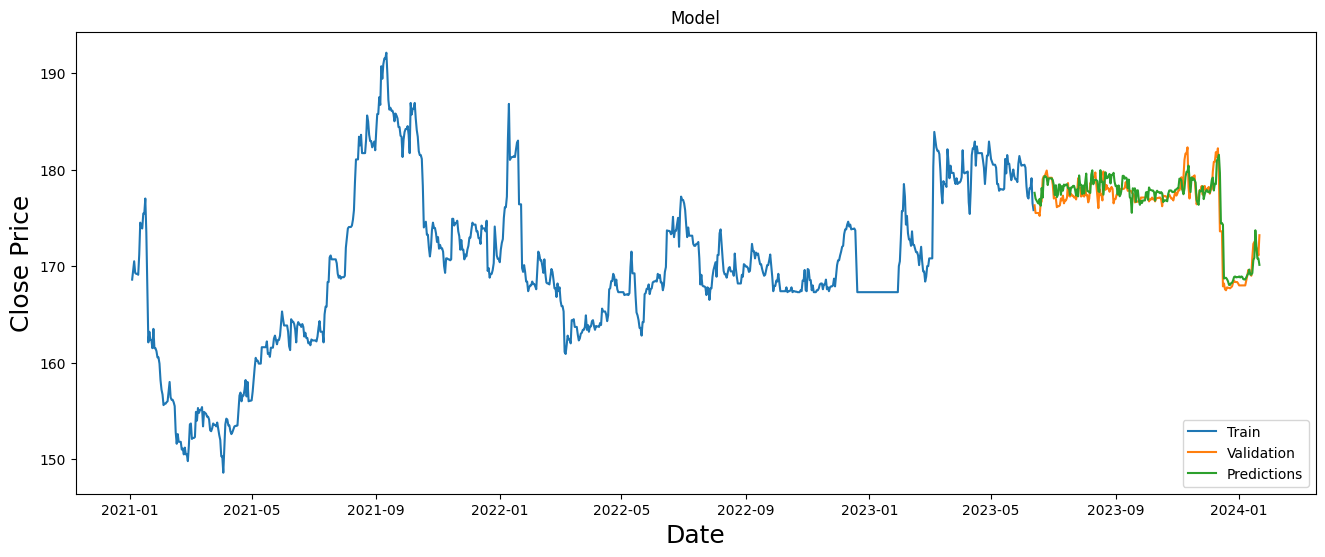

In [108]:
XDF1 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
Target = '1_day'
run_xgboost(XDF1, Features, Target, random_state)

Mean Squared Error: 8.508459353326476
Root Mean Squared Error: 2.916926353771462
R-squared: 0.3403083522723406


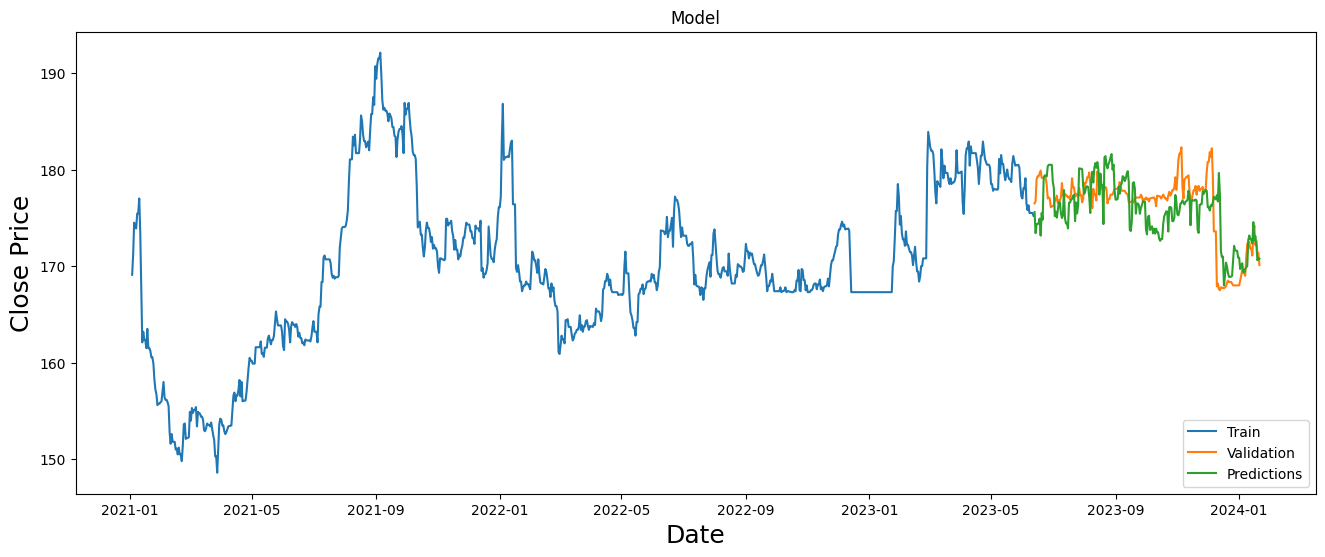

In [109]:
XDF7 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
Target = '1_week'
run_xgboost(XDF7, Features, Target, random_state)

Mean Squared Error: 14.801243336333812
Root Mean Squared Error: 3.847238403885807
R-squared: -0.12474639452667313


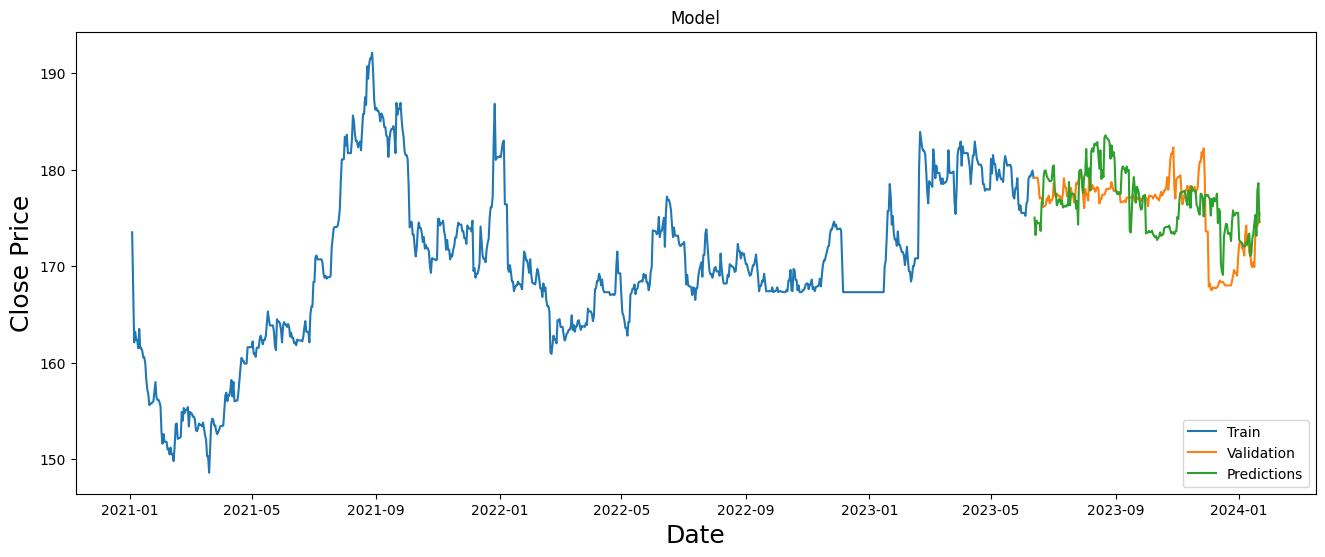

In [110]:
XDF15 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
Target = '15_days'
run_xgboost(XDF15, Features, Target, random_state)

# With SMA_7, MACD, ema

Mean Squared Error: 1.570
Root Mean Squared Error: 1.253
R-squared Score: 0.873


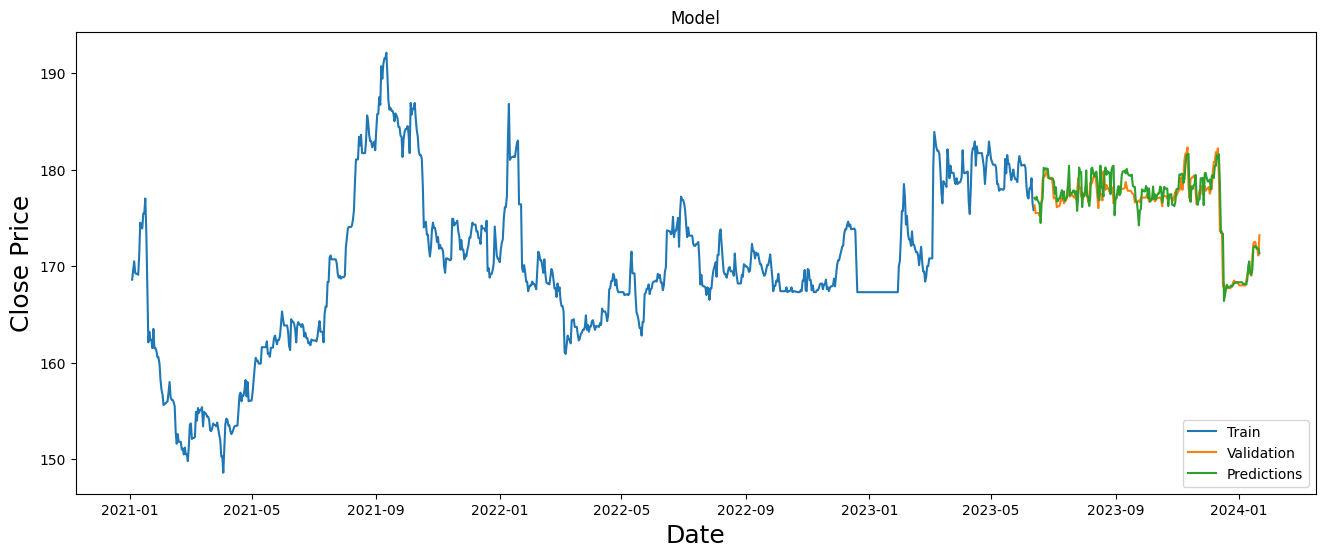

(1.5697318530143172, 1.2528894017487406, 0.8732046364638829)

In [117]:
RfDF1 = Dataset.copy()
n_estimators = 150
random_state = 15
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
target = '1_day'
run_random_forest(RfDF1, n_estimators, random_state,features, target)

Mean Squared Error: 7.665
Root Mean Squared Error: 2.769
R-squared Score: 0.406


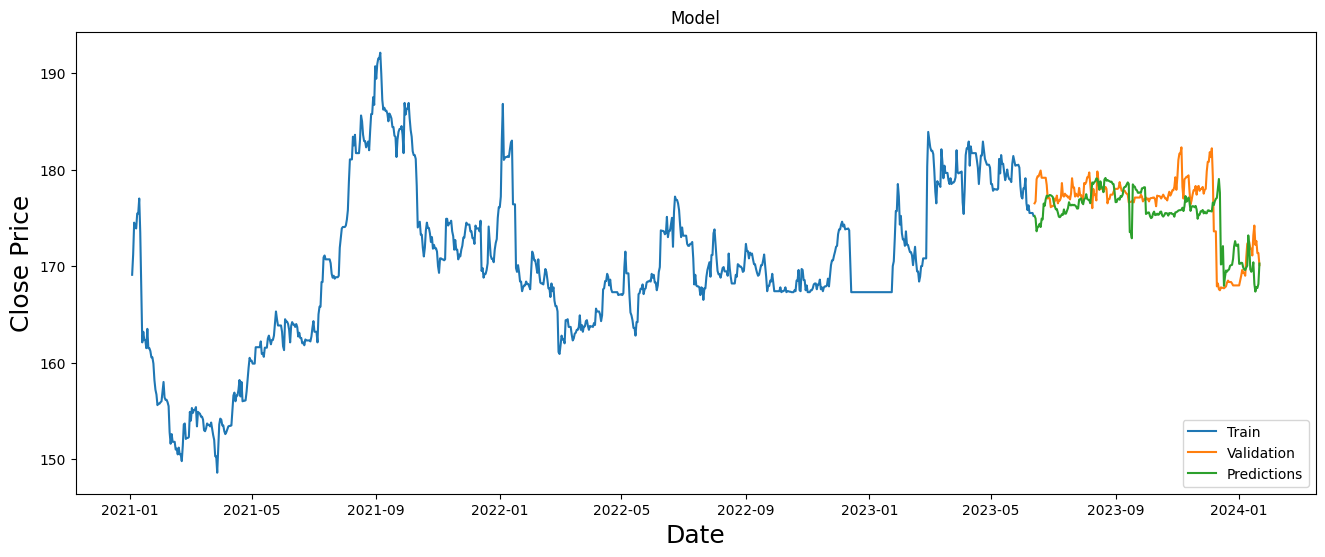

(7.665107980401956, 2.7685931410017535, 0.40569643649706544)

In [112]:
RfDF7 = Dataset.copy()
n_estimators = 90
random_state =15
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
target = '1_week'
run_random_forest(RfDF7, n_estimators, random_state,features, target)

Mean Squared Error: 11.335
Root Mean Squared Error: 3.367
R-squared Score: 0.139


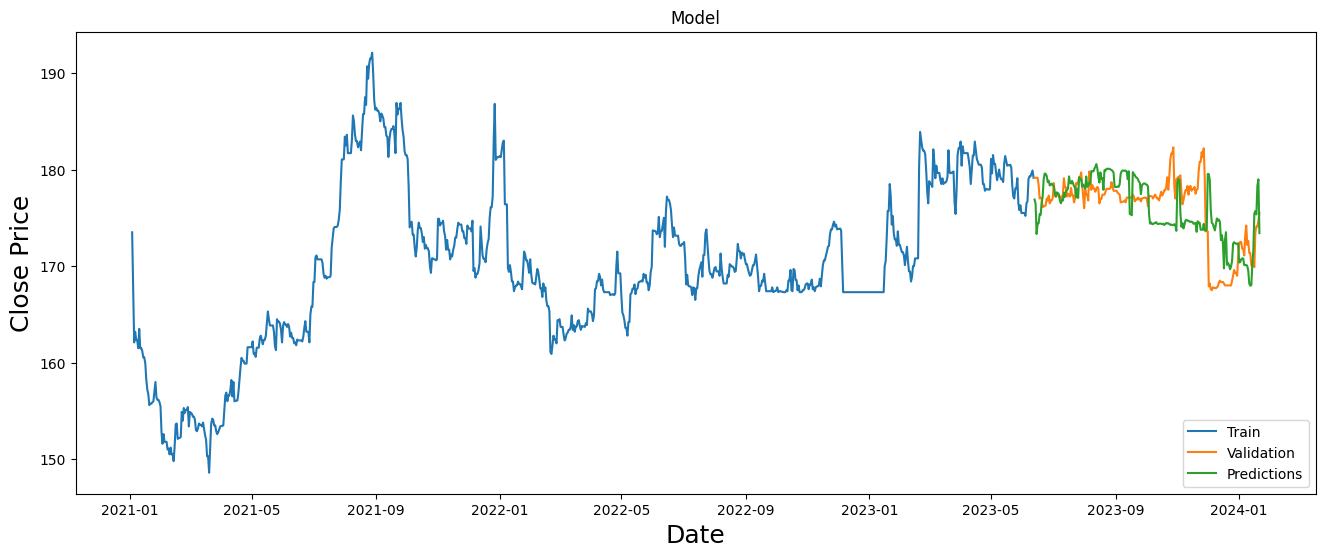

(11.334953631819756, 3.3667422877048008, 0.13865693983826255)

In [118]:
RfDF15 = Dataset.copy()
n_estimators = 120
random_state =15
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
target = '15_days'
run_random_forest(RfDF15, n_estimators, random_state,features, target)

In [119]:
LDF1 = Dataset.copy()
epochs = 90
batch_size = 40
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
target = '1_day'
train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv=LSTM_Model(LDF1,features,target, epochs, batch_size)


['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'SMA_7', 'MACD', 'ema']
1_day
90
40
Epoch 1/90
23/23 - 3s - loss: 0.0499 - 3s/epoch - 110ms/step
Epoch 2/90
23/23 - 0s - loss: 0.0072 - 201ms/epoch - 9ms/step
Epoch 3/90
23/23 - 0s - loss: 0.0040 - 201ms/epoch - 9ms/step
Epoch 4/90
23/23 - 0s - loss: 0.0036 - 185ms/epoch - 8ms/step
Epoch 5/90
23/23 - 0s - loss: 0.0034 - 185ms/epoch - 8ms/step
Epoch 6/90
23/23 - 0s - loss: 0.0031 - 185ms/epoch - 8ms/step
Epoch 7/90
23/23 - 0s - loss: 0.0029 - 185ms/epoch - 8ms/step
Epoch 8/90
23/23 - 0s - loss: 0.0030 - 185ms/epoch - 8ms/step
Epoch 9/90
23/23 - 0s - loss: 0.0026 - 185ms/epoch - 8ms/step
Epoch 10/90
23/23 - 0s - loss: 0.0025 - 178ms/epoch - 8ms/step
Epoch 11/90
23/23 - 0s - loss: 0.0025 - 185ms/epoch - 8ms/step
Epoch 12/90
23/23 - 0s - loss: 0.0024 - 185ms/epoch - 8ms/step
Epoch 13/90
23/23 - 0s - loss: 0.0024 - 201ms/epoch - 9ms/step
Epoch 14/90
23/23 - 0s - loss: 0.0026 - 185ms/epoch - 8ms/step
Epoch 15/90
23/23 - 0s - 

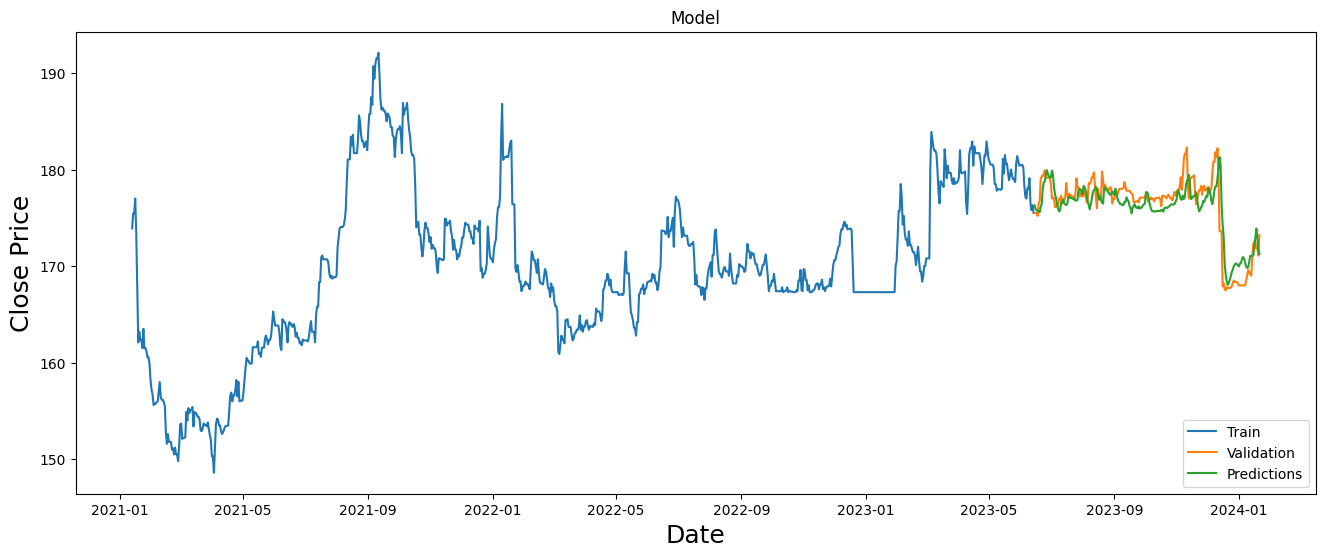

In [120]:
linegraph(train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv)

In [128]:
LDF7 = Dataset.copy()
epochs = 280
batch_size = 40
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
target = '1_week'
train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv=LSTM_Model(LDF7,features,target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'SMA_7', 'MACD', 'ema']
1_week
280
40
Epoch 1/280
23/23 - 2s - loss: 0.0828 - 2s/epoch - 108ms/step
Epoch 2/280
23/23 - 0s - loss: 0.0113 - 185ms/epoch - 8ms/step
Epoch 3/280
23/23 - 0s - loss: 0.0087 - 201ms/epoch - 9ms/step
Epoch 4/280
23/23 - 0s - loss: 0.0080 - 185ms/epoch - 8ms/step
Epoch 5/280
23/23 - 0s - loss: 0.0077 - 185ms/epoch - 8ms/step
Epoch 6/280
23/23 - 0s - loss: 0.0070 - 185ms/epoch - 8ms/step
Epoch 7/280
23/23 - 0s - loss: 0.0065 - 201ms/epoch - 9ms/step
Epoch 8/280
23/23 - 0s - loss: 0.0059 - 178ms/epoch - 8ms/step
Epoch 9/280
23/23 - 0s - loss: 0.0053 - 185ms/epoch - 8ms/step
Epoch 10/280
23/23 - 0s - loss: 0.0050 - 185ms/epoch - 8ms/step
Epoch 11/280
23/23 - 0s - loss: 0.0046 - 185ms/epoch - 8ms/step
Epoch 12/280
23/23 - 0s - loss: 0.0044 - 185ms/epoch - 8ms/step
Epoch 13/280
23/23 - 0s - loss: 0.0042 - 169ms/epoch - 7ms/step
Epoch 14/280
23/23 - 0s - loss: 0.0040 - 185ms/epoch - 8ms/step
Epoch 15/

23/23 - 0s - loss: 0.0012 - 216ms/epoch - 9ms/step
Epoch 128/280
23/23 - 0s - loss: 0.0013 - 216ms/epoch - 9ms/step
Epoch 129/280
23/23 - 0s - loss: 0.0012 - 185ms/epoch - 8ms/step
Epoch 130/280
23/23 - 0s - loss: 0.0011 - 201ms/epoch - 9ms/step
Epoch 131/280
23/23 - 0s - loss: 0.0012 - 201ms/epoch - 9ms/step
Epoch 132/280
23/23 - 0s - loss: 0.0010 - 185ms/epoch - 8ms/step
Epoch 133/280
23/23 - 0s - loss: 0.0012 - 185ms/epoch - 8ms/step
Epoch 134/280
23/23 - 0s - loss: 0.0013 - 185ms/epoch - 8ms/step
Epoch 135/280
23/23 - 0s - loss: 0.0011 - 178ms/epoch - 8ms/step
Epoch 136/280
23/23 - 0s - loss: 0.0012 - 185ms/epoch - 8ms/step
Epoch 137/280
23/23 - 0s - loss: 0.0011 - 185ms/epoch - 8ms/step
Epoch 138/280
23/23 - 0s - loss: 0.0011 - 185ms/epoch - 8ms/step
Epoch 139/280
23/23 - 0s - loss: 0.0010 - 185ms/epoch - 8ms/step
Epoch 140/280
23/23 - 0s - loss: 0.0011 - 169ms/epoch - 7ms/step
Epoch 141/280
23/23 - 0s - loss: 0.0010 - 201ms/epoch - 9ms/step
Epoch 142/280
23/23 - 0s - loss: 0.0012

Epoch 249/280
23/23 - 0s - loss: 7.4070e-04 - 185ms/epoch - 8ms/step
Epoch 250/280
23/23 - 0s - loss: 7.7625e-04 - 185ms/epoch - 8ms/step
Epoch 251/280
23/23 - 0s - loss: 7.9455e-04 - 178ms/epoch - 8ms/step
Epoch 252/280
23/23 - 0s - loss: 8.1043e-04 - 207ms/epoch - 9ms/step
Epoch 253/280
23/23 - 0s - loss: 7.5060e-04 - 178ms/epoch - 8ms/step
Epoch 254/280
23/23 - 0s - loss: 8.1893e-04 - 201ms/epoch - 9ms/step
Epoch 255/280
23/23 - 0s - loss: 0.0011 - 185ms/epoch - 8ms/step
Epoch 256/280
23/23 - 0s - loss: 7.3396e-04 - 185ms/epoch - 8ms/step
Epoch 257/280
23/23 - 0s - loss: 7.4802e-04 - 216ms/epoch - 9ms/step
Epoch 258/280
23/23 - 0s - loss: 7.7090e-04 - 169ms/epoch - 7ms/step
Epoch 259/280
23/23 - 0s - loss: 7.5117e-04 - 216ms/epoch - 9ms/step
Epoch 260/280
23/23 - 0s - loss: 8.0912e-04 - 185ms/epoch - 8ms/step
Epoch 261/280
23/23 - 0s - loss: 7.4301e-04 - 185ms/epoch - 8ms/step
Epoch 262/280
23/23 - 0s - loss: 7.2790e-04 - 185ms/epoch - 8ms/step
Epoch 263/280
23/23 - 0s - loss: 8.810

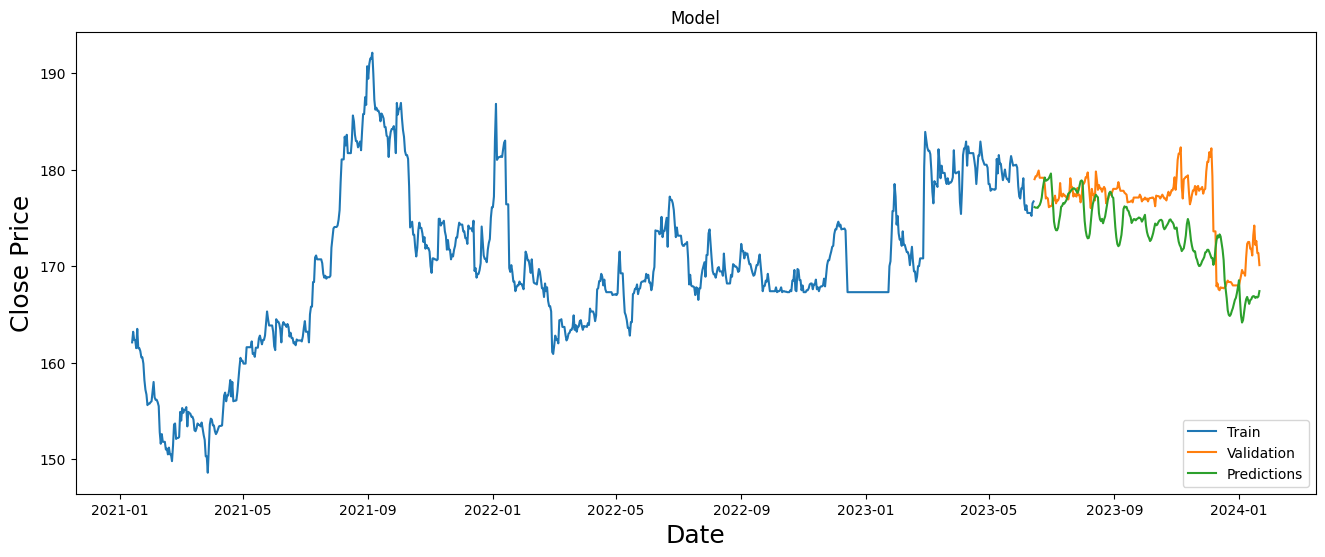

In [129]:
linegraph(train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv)

In [137]:
LDF15 = Dataset.copy()
epochs = 300
batch_size = 40
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
target = '15_days'
train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv=LSTM_Model(LDF15,features,target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'SMA_7', 'MACD', 'ema']
15_days
300
40
Epoch 1/300
23/23 - 2s - loss: 0.0440 - 2s/epoch - 104ms/step
Epoch 2/300
23/23 - 0s - loss: 0.0127 - 185ms/epoch - 8ms/step
Epoch 3/300
23/23 - 0s - loss: 0.0115 - 185ms/epoch - 8ms/step
Epoch 4/300
23/23 - 0s - loss: 0.0101 - 185ms/epoch - 8ms/step
Epoch 5/300
23/23 - 0s - loss: 0.0087 - 185ms/epoch - 8ms/step
Epoch 6/300
23/23 - 0s - loss: 0.0071 - 194ms/epoch - 8ms/step
Epoch 7/300
23/23 - 0s - loss: 0.0064 - 185ms/epoch - 8ms/step
Epoch 8/300
23/23 - 0s - loss: 0.0060 - 185ms/epoch - 8ms/step
Epoch 9/300
23/23 - 0s - loss: 0.0055 - 185ms/epoch - 8ms/step
Epoch 10/300
23/23 - 0s - loss: 0.0054 - 185ms/epoch - 8ms/step
Epoch 11/300
23/23 - 0s - loss: 0.0053 - 185ms/epoch - 8ms/step
Epoch 12/300
23/23 - 0s - loss: 0.0049 - 185ms/epoch - 8ms/step
Epoch 13/300
23/23 - 0s - loss: 0.0050 - 194ms/epoch - 8ms/step
Epoch 14/300
23/23 - 0s - loss: 0.0052 - 178ms/epoch - 8ms/step
Epoch 15

23/23 - 0s - loss: 0.0011 - 180ms/epoch - 8ms/step
Epoch 128/300
23/23 - 0s - loss: 0.0015 - 180ms/epoch - 8ms/step
Epoch 129/300
23/23 - 0s - loss: 0.0031 - 180ms/epoch - 8ms/step
Epoch 130/300
23/23 - 0s - loss: 0.0016 - 180ms/epoch - 8ms/step
Epoch 131/300
23/23 - 0s - loss: 0.0012 - 180ms/epoch - 8ms/step
Epoch 132/300
23/23 - 0s - loss: 0.0011 - 180ms/epoch - 8ms/step
Epoch 133/300
23/23 - 0s - loss: 0.0012 - 180ms/epoch - 8ms/step
Epoch 134/300
23/23 - 0s - loss: 0.0011 - 186ms/epoch - 8ms/step
Epoch 135/300
23/23 - 0s - loss: 0.0011 - 186ms/epoch - 8ms/step
Epoch 136/300
23/23 - 0s - loss: 0.0012 - 180ms/epoch - 8ms/step
Epoch 137/300
23/23 - 0s - loss: 0.0011 - 180ms/epoch - 8ms/step
Epoch 138/300
23/23 - 0s - loss: 0.0010 - 180ms/epoch - 8ms/step
Epoch 139/300
23/23 - 0s - loss: 0.0011 - 180ms/epoch - 8ms/step
Epoch 140/300
23/23 - 0s - loss: 0.0012 - 180ms/epoch - 8ms/step
Epoch 141/300
23/23 - 0s - loss: 0.0012 - 174ms/epoch - 8ms/step
Epoch 142/300
23/23 - 0s - loss: 0.0011

23/23 - 0s - loss: 0.0010 - 169ms/epoch - 7ms/step
Epoch 249/300
23/23 - 0s - loss: 0.0010 - 185ms/epoch - 8ms/step
Epoch 250/300
23/23 - 0s - loss: 8.1358e-04 - 178ms/epoch - 8ms/step
Epoch 251/300
23/23 - 0s - loss: 7.4413e-04 - 169ms/epoch - 7ms/step
Epoch 252/300
23/23 - 0s - loss: 6.7849e-04 - 169ms/epoch - 7ms/step
Epoch 253/300
23/23 - 0s - loss: 8.6354e-04 - 169ms/epoch - 7ms/step
Epoch 254/300
23/23 - 0s - loss: 8.2888e-04 - 178ms/epoch - 8ms/step
Epoch 255/300
23/23 - 0s - loss: 8.5442e-04 - 169ms/epoch - 7ms/step
Epoch 256/300
23/23 - 0s - loss: 7.7038e-04 - 185ms/epoch - 8ms/step
Epoch 257/300
23/23 - 0s - loss: 6.8588e-04 - 169ms/epoch - 7ms/step
Epoch 258/300
23/23 - 0s - loss: 0.0011 - 185ms/epoch - 8ms/step
Epoch 259/300
23/23 - 0s - loss: 8.1223e-04 - 178ms/epoch - 8ms/step
Epoch 260/300
23/23 - 0s - loss: 6.8865e-04 - 201ms/epoch - 9ms/step
Epoch 261/300
23/23 - 0s - loss: 6.5114e-04 - 169ms/epoch - 7ms/step
Epoch 262/300
23/23 - 0s - loss: 6.1291e-04 - 185ms/epoch - 

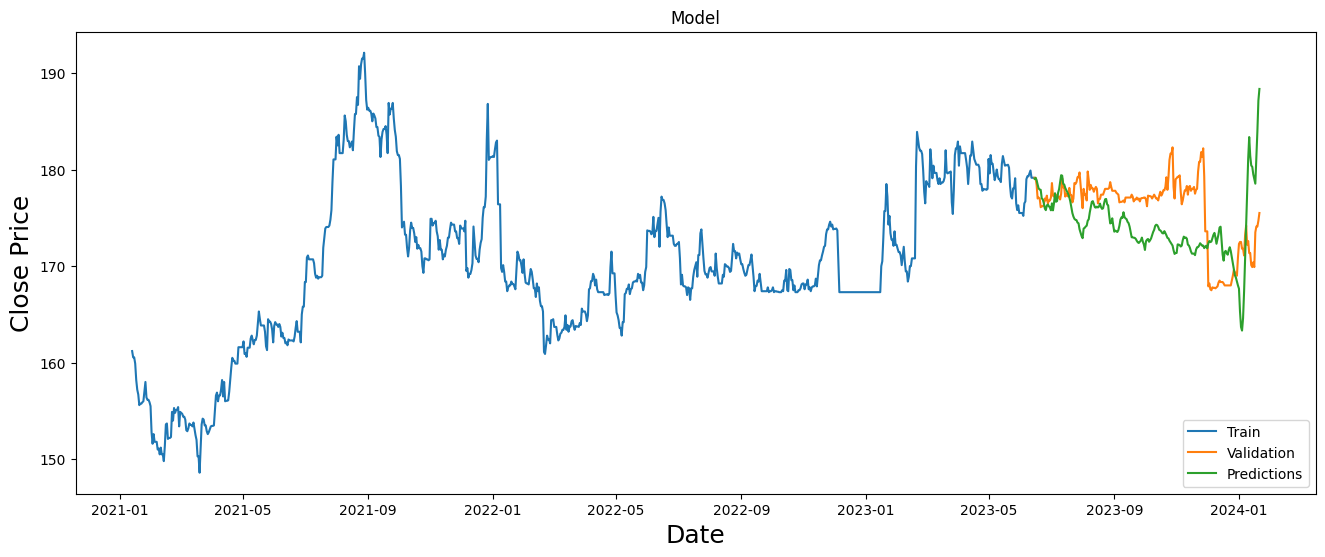

In [138]:
linegraph(train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv)

# GRU

In [142]:
GDF1 = Dataset.copy()
epochs = 100
batch_size = 30
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
Target = '1_day'
GRU_Model(GDF1,Features, Target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'SMA_7', 'MACD', 'ema']
1_day
100
30
Epoch 1/100
30/30 [==============================] - 8s 16ms/step - loss: 0.0132
Epoch 2/100
30/30 [==============================] - 0s 16ms/step - loss: 0.0030
Epoch 3/100
30/30 [==============================] - 0s 16ms/step - loss: 0.0028
Epoch 4/100
30/30 [==============================] - 0s 16ms/step - loss: 0.0026
Epoch 5/100
30/30 [==============================] - 0s 16ms/step - loss: 0.0026
Epoch 6/100
30/30 [==============================] - 0s 16ms/step - loss: 0.0026
Epoch 7/100
30/30 [==============================] - 1s 16ms/step - loss: 0.0025
Epoch 8/100
30/30 [==============================] - 0s 16ms/step - loss: 0.0022
Epoch 9/100
30/30 [==============================] - 1s 16ms/step - loss: 0.0022
Epoch 10/100
30/30 [==============================] - 0s 16ms/step - loss: 0.0025
Epoch 11/100
30/30 [==============================] - 0s 16ms/step - loss: 0.0022
Epo

30/30 [==============================] - 1s 17ms/step - loss: 0.0013
Epoch 100/100
7/7 [==============================] - 1s 8ms/step
Mean Squared Error (MSE): 2.342
Root Mean Squared Error (RMSE): 1.530
R-squared Score (R2): 0.813


In [146]:
GDF7 = Dataset.copy()
epochs = 70
batch_size = 30
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
Target = '1_week'
GRU_Model(GDF7,Features, Target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'SMA_7', 'MACD', 'ema']
1_week
70
30
Epoch 1/70
30/30 [==============================] - 7s 16ms/step - loss: 0.0736
Epoch 2/70
30/30 [==============================] - 0s 16ms/step - loss: 0.0095
Epoch 3/70
30/30 [==============================] - 0s 16ms/step - loss: 0.0075
Epoch 4/70
30/30 [==============================] - 1s 17ms/step - loss: 0.0073
Epoch 5/70
30/30 [==============================] - 0s 16ms/step - loss: 0.0072
Epoch 6/70
30/30 [==============================] - 0s 15ms/step - loss: 0.0068
Epoch 7/70
30/30 [==============================] - 0s 16ms/step - loss: 0.0067
Epoch 8/70
30/30 [==============================] - 0s 16ms/step - loss: 0.0065
Epoch 9/70
30/30 [==============================] - 0s 16ms/step - loss: 0.0066
Epoch 10/70
30/30 [==============================] - 0s 15ms/step - loss: 0.0063
Epoch 11/70
30/30 [==============================] - 0s 16ms/step - loss: 0.0071
Epoch 12/70
30

In [147]:
GDF15 = Dataset.copy()
epochs = 80
batch_size = 30
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
Target = '15_days'
GRU_Model(GDF15,Features, Target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'SMA_7', 'MACD', 'ema']
15_days
80
30
Epoch 1/80
30/30 [==============================] - 7s 18ms/step - loss: 0.0298
Epoch 2/80
30/30 [==============================] - 1s 17ms/step - loss: 0.0118
Epoch 3/80
30/30 [==============================] - 1s 16ms/step - loss: 0.0105
Epoch 4/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0108
Epoch 5/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0101
Epoch 6/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0101
Epoch 7/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0097
Epoch 8/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0096
Epoch 9/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0092
Epoch 10/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0087
Epoch 11/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0075
Epoch 12/80
3

# XGBoost

Mean Squared Error: 1.281818652007639
Root Mean Squared Error: 1.1321743028384097
R-squared: 0.8964608753676085


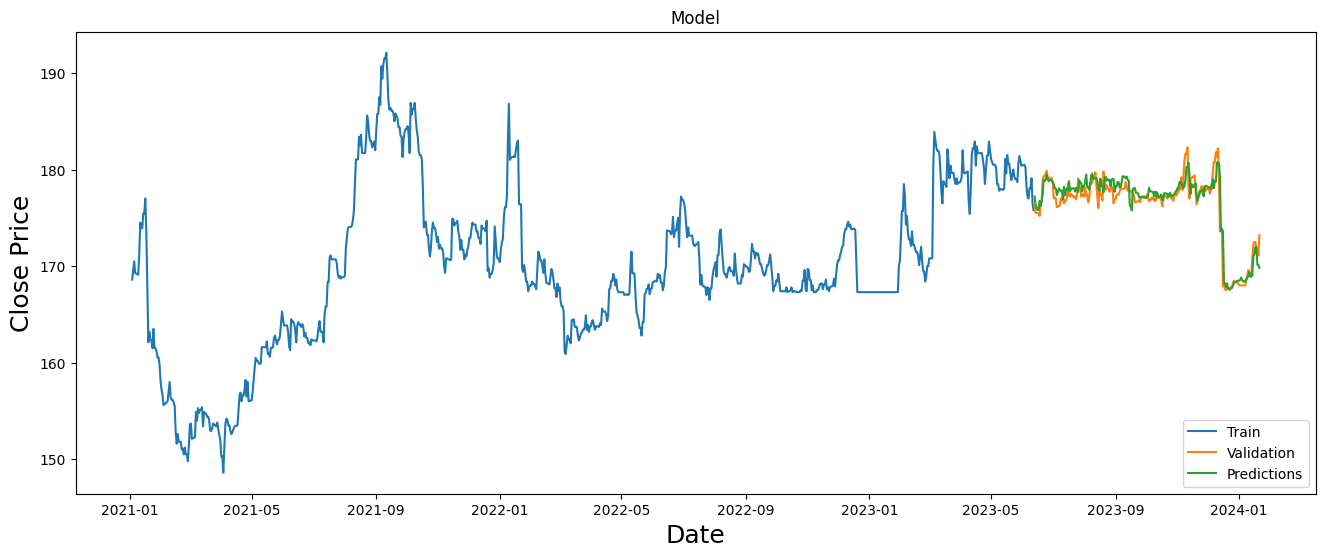

In [148]:
XDF1 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
Target = '1_day'
run_xgboost(XDF1, Features, Target, random_state)

Mean Squared Error: 8.264801616020787
Root Mean Squared Error: 2.874856799219882
R-squared: 0.3592000184988401


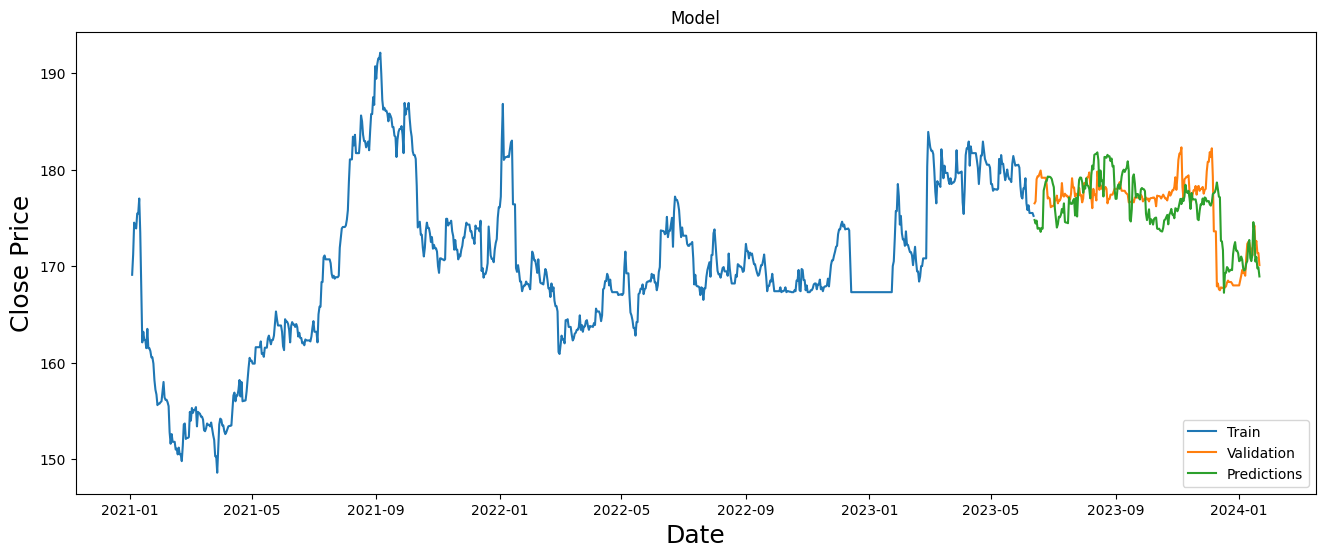

In [149]:
XDF7 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
Target = '1_week'
run_xgboost(XDF7, Features, Target, random_state)

Mean Squared Error: 13.304697394049288
Root Mean Squared Error: 3.6475604716096606
R-squared: -0.011023877128687465


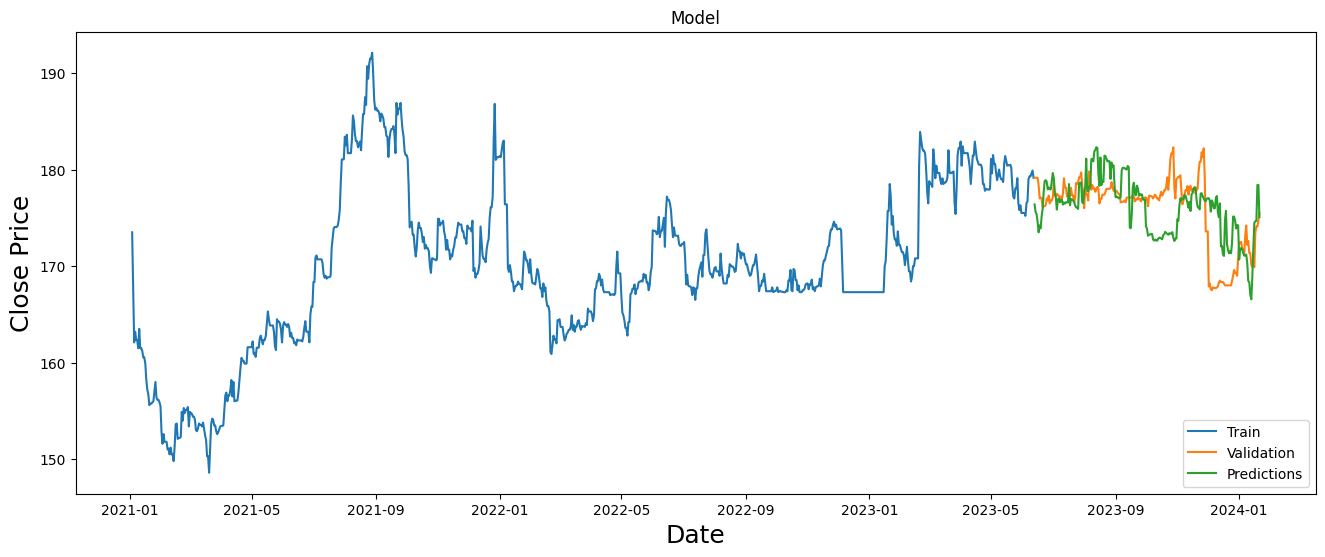

In [150]:
XDF15 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
Target = '15_days'
run_xgboost(XDF15, Features, Target, random_state)

# Ensebled Algorithm

In [151]:
Dataset.head()

,Date,Open,High,Low,Close,Volume,day,month,year,1_day,1_week,15_days,1_month,SMA_7,MACD,Signal_Line,ema
0,2021-01-03,166.9,169.0,165.0,167.9,156205.0,3,1,2021,168.6,169.1,173.50,157.20,167.9,0.000000,0.000000,167.900000
1,2021-01-04,167.1,170.0,166.6,168.6,89695.0,4,1,2021,169.6,171.2,167.80,156.70,167.9,-0.055840,-0.011168,168.133333
2,2021-01-05,169.6,173.2,169.1,169.6,98023.0,5,1,2021,170.5,174.5,162.10,155.60,167.9,-0.178726,-0.044680,168.622222
3,2021-01-06,172.0,172.0,168.5,170.5,50243.0,6,1,2021,169.3,174.0,163.20,155.75,167.9,-0.344762,-0.104696,169.248148
4,2021-01-07,171.9,172.0,168.4,169.3,94333.0,7,1,2021,169.2,173.9,162.35,155.75,167.9,-0.375191,-0.158795,169.265432


In [152]:
def split_dataset(Feat, Tar, ran_state):
    Features = Feat
    Target = Tar
    random = ran_state
    X_train, X_test, y_train, y_test = train_test_split(
        Features,
        Target,
        test_size=0.2,
        random_state=random,
        shuffle=False
    )
    return X_train, X_test, y_train, y_test

In [153]:
def create_sequences(DF, sequence_length):
    X, y = [], []
    for i in range(len(DF) - sequence_length):
        X.append(DF[i:(i + sequence_length), :-1])
        y.append(DF[i + sequence_length, -1])
    X, y = np.array(X), np.array(y)
    return X, y.reshape(-1,1)

In [154]:
from sklearn.metrics import mean_squared_error
from numpy import sqrt, mean, array
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
import numpy as np

def LSTM_Model(X_train, X_test, y_train, epochs, batch_size, scaler):
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)
    y_pred = model.predict(X_test)
    X_test_reshaped = X_test[:, -1, :]
    y_pred_inv = scaler.inverse_transform(np.concatenate((X_test_reshaped, y_pred), axis=1))[:, -1]
    return y_pred_inv

def GRU_Model(X_train, X_test, y_train, epochs, batch_size, scaler):
    model = Sequential()
    model.add(GRU(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)
    y_pred = model.predict(X_test)
    X_test_reshaped = X_test[:, -1, :]
    y_pred_inv = scaler.inverse_transform(np.concatenate((X_test_reshaped, y_pred), axis=1))[:, -1]
    return y_pred_inv

def random_forest_model(X_train, X_test, y_train):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

def xgboost_model(X_train, X_test, y_train):
    model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                             max_depth = 5, alpha = 10, n_estimators = 100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

def ensemble_model(EDF1, Features, Target, epochs, batch_size, n_estimators, sequence_length, random_state):
    from sklearn.metrics import mean_squared_error
    from numpy import sqrt, mean, array
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    import xgboost as xgb
    from keras.models import Sequential
    from keras.layers import LSTM, GRU, Dense
    import numpy as np

    # Prepare and scale data
    scaler = MinMaxScaler()
    DF_scaled = scaler.fit_transform(EDF1[Features + [Target]])
    X_seq, y_seq = create_sequences(DF_scaled, sequence_length)

    X_train, X_test, y_train, y_test = split_dataset(X_seq, y_seq, random_state)
    X_train1, X_test1, y_train1, y_test1 = split_dataset(EDF1[Features], EDF1[Target], random_state)
    # Reshape for RF and XGB: taking the last timestep of each sequence
    X_train_last = X_train[:, -1, :]
    X_test_last = X_test[:, -1, :]
    
    # Train and predict with each model
    lstm_predictions = LSTM_Model(X_train, X_test, y_train, epochs, batch_size, scaler)
    gru_predictions = GRU_Model(X_train, X_test, y_train, epochs, batch_size, scaler)
    rf_predictions = random_forest_model(X_train1, X_test1, y_train1)
    xgb_predictions = xgboost_model(X_train1, X_test1,y_train1)
   
    # Inverse transform y_test and predictions to original scale
    # y_test_original = scaler.inverse_transform(np.concatenate((X_test_last, y_test), axis=1))[:, -1]
    # Ensure all predictions are in the original scale
    average_predictions = mean(array([lstm_predictions, gru_predictions, rf_predictions, xgb_predictions]), axis=0)
    # Calculate RMSE
    mse = mean_squared_error(y_test1, average_predictions)
    rmse = sqrt(mse)
    return rmse

In [155]:
EDF1 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
Target = '1_day'
epochs = 90
batch_size = 40
n_estimators = 80
sequence_length = 1
rmse= ensemble_model(EDF1, Features, Target, epochs, batch_size, n_estimators, sequence_length, random_state)
print(rmse)

Epoch 1/90
23/23 - 2s - loss: 0.1906 - 2s/epoch - 104ms/step
Epoch 2/90
23/23 - 0s - loss: 0.0610 - 69ms/epoch - 3ms/step
Epoch 3/90
23/23 - 0s - loss: 0.0073 - 69ms/epoch - 3ms/step
Epoch 4/90
23/23 - 0s - loss: 0.0049 - 78ms/epoch - 3ms/step
Epoch 5/90
23/23 - 0s - loss: 0.0042 - 85ms/epoch - 4ms/step
Epoch 6/90
23/23 - 0s - loss: 0.0038 - 85ms/epoch - 4ms/step
Epoch 7/90
23/23 - 0s - loss: 0.0034 - 85ms/epoch - 4ms/step
Epoch 8/90
23/23 - 0s - loss: 0.0031 - 69ms/epoch - 3ms/step
Epoch 9/90
23/23 - 0s - loss: 0.0029 - 78ms/epoch - 3ms/step
Epoch 10/90
23/23 - 0s - loss: 0.0027 - 69ms/epoch - 3ms/step
Epoch 11/90
23/23 - 0s - loss: 0.0026 - 85ms/epoch - 4ms/step
Epoch 12/90
23/23 - 0s - loss: 0.0025 - 85ms/epoch - 4ms/step
Epoch 13/90
23/23 - 0s - loss: 0.0024 - 69ms/epoch - 3ms/step
Epoch 14/90
23/23 - 0s - loss: 0.0024 - 94ms/epoch - 4ms/step
Epoch 15/90
23/23 - 0s - loss: 0.0023 - 69ms/epoch - 3ms/step
Epoch 16/90
23/23 - 0s - loss: 0.0023 - 69ms/epoch - 3ms/step
Epoch 17/90
23/23

Epoch 43/90
23/23 - 0s - loss: 0.0017 - 78ms/epoch - 3ms/step
Epoch 44/90
23/23 - 0s - loss: 0.0018 - 69ms/epoch - 3ms/step
Epoch 45/90
23/23 - 0s - loss: 0.0017 - 85ms/epoch - 4ms/step
Epoch 46/90
23/23 - 0s - loss: 0.0018 - 69ms/epoch - 3ms/step
Epoch 47/90
23/23 - 0s - loss: 0.0018 - 78ms/epoch - 3ms/step
Epoch 48/90
23/23 - 0s - loss: 0.0017 - 69ms/epoch - 3ms/step
Epoch 49/90
23/23 - 0s - loss: 0.0017 - 69ms/epoch - 3ms/step
Epoch 50/90
23/23 - 0s - loss: 0.0018 - 69ms/epoch - 3ms/step
Epoch 51/90
23/23 - 0s - loss: 0.0017 - 63ms/epoch - 3ms/step
Epoch 52/90
23/23 - 0s - loss: 0.0017 - 85ms/epoch - 4ms/step
Epoch 53/90
23/23 - 0s - loss: 0.0017 - 69ms/epoch - 3ms/step
Epoch 54/90
23/23 - 0s - loss: 0.0018 - 62ms/epoch - 3ms/step
Epoch 55/90
23/23 - 0s - loss: 0.0017 - 85ms/epoch - 4ms/step
Epoch 56/90
23/23 - 0s - loss: 0.0017 - 69ms/epoch - 3ms/step
Epoch 57/90
23/23 - 0s - loss: 0.0018 - 69ms/epoch - 3ms/step
Epoch 58/90
23/23 - 0s - loss: 0.0017 - 78ms/epoch - 3ms/step
Epoch 59

In [156]:
EDF2 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
Target = '1_week'
epochs = 90
batch_size = 40
n_estimators = 80
sequence_length = 1
rmse= ensemble_model(EDF2, Features, Target, epochs, batch_size, n_estimators, sequence_length, random_state)
print(rmse)

Epoch 1/90
23/23 - 3s - loss: 0.1849 - 3s/epoch - 122ms/step
Epoch 2/90
23/23 - 0s - loss: 0.0520 - 85ms/epoch - 4ms/step
Epoch 3/90
23/23 - 0s - loss: 0.0118 - 85ms/epoch - 4ms/step
Epoch 4/90
23/23 - 0s - loss: 0.0103 - 69ms/epoch - 3ms/step
Epoch 5/90
23/23 - 0s - loss: 0.0091 - 78ms/epoch - 3ms/step
Epoch 6/90
23/23 - 0s - loss: 0.0082 - 85ms/epoch - 4ms/step
Epoch 7/90
23/23 - 0s - loss: 0.0078 - 85ms/epoch - 4ms/step
Epoch 8/90
23/23 - 0s - loss: 0.0075 - 85ms/epoch - 4ms/step
Epoch 9/90
23/23 - 0s - loss: 0.0073 - 85ms/epoch - 4ms/step
Epoch 10/90
23/23 - 0s - loss: 0.0072 - 69ms/epoch - 3ms/step
Epoch 11/90
23/23 - 0s - loss: 0.0071 - 94ms/epoch - 4ms/step
Epoch 12/90
23/23 - 0s - loss: 0.0069 - 85ms/epoch - 4ms/step
Epoch 13/90
23/23 - 0s - loss: 0.0069 - 100ms/epoch - 4ms/step
Epoch 14/90
23/23 - 0s - loss: 0.0067 - 85ms/epoch - 4ms/step
Epoch 15/90
23/23 - 0s - loss: 0.0067 - 85ms/epoch - 4ms/step
Epoch 16/90
23/23 - 0s - loss: 0.0066 - 69ms/epoch - 3ms/step
Epoch 17/90
23/2

Epoch 43/90
23/23 - 0s - loss: 0.0050 - 85ms/epoch - 4ms/step
Epoch 44/90
23/23 - 0s - loss: 0.0050 - 85ms/epoch - 4ms/step
Epoch 45/90
23/23 - 0s - loss: 0.0051 - 69ms/epoch - 3ms/step
Epoch 46/90
23/23 - 0s - loss: 0.0051 - 94ms/epoch - 4ms/step
Epoch 47/90
23/23 - 0s - loss: 0.0050 - 85ms/epoch - 4ms/step
Epoch 48/90
23/23 - 0s - loss: 0.0049 - 69ms/epoch - 3ms/step
Epoch 49/90
23/23 - 0s - loss: 0.0049 - 85ms/epoch - 4ms/step
Epoch 50/90
23/23 - 0s - loss: 0.0049 - 69ms/epoch - 3ms/step
Epoch 51/90
23/23 - 0s - loss: 0.0049 - 78ms/epoch - 3ms/step
Epoch 52/90
23/23 - 0s - loss: 0.0050 - 69ms/epoch - 3ms/step
Epoch 53/90
23/23 - 0s - loss: 0.0050 - 85ms/epoch - 4ms/step
Epoch 54/90
23/23 - 0s - loss: 0.0050 - 69ms/epoch - 3ms/step
Epoch 55/90
23/23 - 0s - loss: 0.0049 - 69ms/epoch - 3ms/step
Epoch 56/90
23/23 - 0s - loss: 0.0048 - 78ms/epoch - 3ms/step
Epoch 57/90
23/23 - 0s - loss: 0.0049 - 85ms/epoch - 4ms/step
Epoch 58/90
23/23 - 0s - loss: 0.0048 - 85ms/epoch - 4ms/step
Epoch 59

In [157]:
EDF3 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
Target = '15_days'
epochs = 90
batch_size = 40
n_estimators = 80
sequence_length = 1
rmse= ensemble_model(EDF3, Features, Target, epochs, batch_size, n_estimators, sequence_length, random_state)
print(rmse)

Epoch 1/90
23/23 - 2s - loss: 0.1998 - 2s/epoch - 107ms/step
Epoch 2/90
23/23 - 0s - loss: 0.0707 - 92ms/epoch - 4ms/step
Epoch 3/90
23/23 - 0s - loss: 0.0165 - 80ms/epoch - 3ms/step
Epoch 4/90
23/23 - 0s - loss: 0.0142 - 80ms/epoch - 3ms/step
Epoch 5/90
23/23 - 0s - loss: 0.0132 - 72ms/epoch - 3ms/step
Epoch 6/90
23/23 - 0s - loss: 0.0127 - 84ms/epoch - 4ms/step
Epoch 7/90
23/23 - 0s - loss: 0.0123 - 76ms/epoch - 3ms/step
Epoch 8/90
23/23 - 0s - loss: 0.0120 - 84ms/epoch - 4ms/step
Epoch 9/90
23/23 - 0s - loss: 0.0117 - 80ms/epoch - 3ms/step
Epoch 10/90
23/23 - 0s - loss: 0.0114 - 80ms/epoch - 3ms/step
Epoch 11/90
23/23 - 0s - loss: 0.0112 - 84ms/epoch - 4ms/step
Epoch 12/90
23/23 - 0s - loss: 0.0111 - 84ms/epoch - 4ms/step
Epoch 13/90
23/23 - 0s - loss: 0.0110 - 80ms/epoch - 3ms/step
Epoch 14/90
23/23 - 0s - loss: 0.0109 - 76ms/epoch - 3ms/step
Epoch 15/90
23/23 - 0s - loss: 0.0108 - 80ms/epoch - 3ms/step
Epoch 16/90
23/23 - 0s - loss: 0.0108 - 84ms/epoch - 4ms/step
Epoch 17/90
23/23

Epoch 43/90
23/23 - 0s - loss: 0.0066 - 92ms/epoch - 4ms/step
Epoch 44/90
23/23 - 0s - loss: 0.0065 - 76ms/epoch - 3ms/step
Epoch 45/90
23/23 - 0s - loss: 0.0066 - 88ms/epoch - 4ms/step
Epoch 46/90
23/23 - 0s - loss: 0.0064 - 72ms/epoch - 3ms/step
Epoch 47/90
23/23 - 0s - loss: 0.0064 - 76ms/epoch - 3ms/step
Epoch 48/90
23/23 - 0s - loss: 0.0064 - 84ms/epoch - 4ms/step
Epoch 49/90
23/23 - 0s - loss: 0.0063 - 76ms/epoch - 3ms/step
Epoch 50/90
23/23 - 0s - loss: 0.0062 - 76ms/epoch - 3ms/step
Epoch 51/90
23/23 - 0s - loss: 0.0063 - 72ms/epoch - 3ms/step
Epoch 52/90
23/23 - 0s - loss: 0.0062 - 80ms/epoch - 3ms/step
Epoch 53/90
23/23 - 0s - loss: 0.0061 - 76ms/epoch - 3ms/step
Epoch 54/90
23/23 - 0s - loss: 0.0061 - 76ms/epoch - 3ms/step
Epoch 55/90
23/23 - 0s - loss: 0.0061 - 76ms/epoch - 3ms/step
Epoch 56/90
23/23 - 0s - loss: 0.0060 - 76ms/epoch - 3ms/step
Epoch 57/90
23/23 - 0s - loss: 0.0061 - 72ms/epoch - 3ms/step
Epoch 58/90
23/23 - 0s - loss: 0.0060 - 80ms/epoch - 3ms/step
Epoch 59

In [158]:
EDF4 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
Target = '1_month'
epochs = 90
batch_size = 40
n_estimators = 80
sequence_length = 1
rmse= ensemble_model(EDF4, Features, Target, epochs, batch_size, n_estimators, sequence_length, random_state)
print(rmse)

Epoch 1/90
23/23 - 2s - loss: 0.1727 - 2s/epoch - 105ms/step
Epoch 2/90
23/23 - 0s - loss: 0.0435 - 85ms/epoch - 4ms/step
Epoch 3/90
23/23 - 0s - loss: 0.0198 - 85ms/epoch - 4ms/step
Epoch 4/90
23/23 - 0s - loss: 0.0183 - 78ms/epoch - 3ms/step
Epoch 5/90
23/23 - 0s - loss: 0.0180 - 85ms/epoch - 4ms/step
Epoch 6/90
23/23 - 0s - loss: 0.0176 - 69ms/epoch - 3ms/step
Epoch 7/90
23/23 - 0s - loss: 0.0172 - 85ms/epoch - 4ms/step
Epoch 8/90
23/23 - 0s - loss: 0.0168 - 100ms/epoch - 4ms/step
Epoch 9/90
23/23 - 0s - loss: 0.0164 - 85ms/epoch - 4ms/step
Epoch 10/90
23/23 - 0s - loss: 0.0159 - 85ms/epoch - 4ms/step
Epoch 11/90
23/23 - 0s - loss: 0.0155 - 94ms/epoch - 4ms/step
Epoch 12/90
23/23 - 0s - loss: 0.0149 - 69ms/epoch - 3ms/step
Epoch 13/90
23/23 - 0s - loss: 0.0145 - 69ms/epoch - 3ms/step
Epoch 14/90
23/23 - 0s - loss: 0.0138 - 85ms/epoch - 4ms/step
Epoch 15/90
23/23 - 0s - loss: 0.0133 - 85ms/epoch - 4ms/step
Epoch 16/90
23/23 - 0s - loss: 0.0126 - 85ms/epoch - 4ms/step
Epoch 17/90
23/2

Epoch 43/90
23/23 - 0s - loss: 0.0067 - 62ms/epoch - 3ms/step
Epoch 44/90
23/23 - 0s - loss: 0.0065 - 85ms/epoch - 4ms/step
Epoch 45/90
23/23 - 0s - loss: 0.0065 - 69ms/epoch - 3ms/step
Epoch 46/90
23/23 - 0s - loss: 0.0065 - 69ms/epoch - 3ms/step
Epoch 47/90
23/23 - 0s - loss: 0.0063 - 63ms/epoch - 3ms/step
Epoch 48/90
23/23 - 0s - loss: 0.0062 - 85ms/epoch - 4ms/step
Epoch 49/90
23/23 - 0s - loss: 0.0061 - 69ms/epoch - 3ms/step
Epoch 50/90
23/23 - 0s - loss: 0.0061 - 78ms/epoch - 3ms/step
Epoch 51/90
23/23 - 0s - loss: 0.0060 - 69ms/epoch - 3ms/step
Epoch 52/90
23/23 - 0s - loss: 0.0059 - 69ms/epoch - 3ms/step
Epoch 53/90
23/23 - 0s - loss: 0.0058 - 69ms/epoch - 3ms/step
Epoch 54/90
23/23 - 0s - loss: 0.0059 - 78ms/epoch - 3ms/step
Epoch 55/90
23/23 - 0s - loss: 0.0058 - 69ms/epoch - 3ms/step
Epoch 56/90
23/23 - 0s - loss: 0.0058 - 85ms/epoch - 4ms/step
Epoch 57/90
23/23 - 0s - loss: 0.0056 - 69ms/epoch - 3ms/step
Epoch 58/90
23/23 - 0s - loss: 0.0056 - 63ms/epoch - 3ms/step
Epoch 59